#### Validation Step 4 | End-to-End Data Analysis

Nick Kern & the HERA Validation Team

September, 2020

### Abstract

This notebook reviews the end-to-end run (step 4) of the H1C validation effort.
We show basic results of the analysis stages, including calibration, inpainting, reflection calibration, xtalk subtraction, LST time averaging (i.e. fringe-rate filtering) and finally, power spectrum estimation.

# Table of Contents

- [0. Data](#data)
- [1. Gain Calibration](#gain-cal)
- [2. Flag Inpainting](#inpaint)
- [3. Reflection Calibration](#refcal)
- [4. Crosstalk Filtering](#xtalk)
- [5. Power Spectra](#pspec)


- [Appendix A. Time Averaging Signal Loss](#tavg-sigloss)
- [Appendix B. Crosstalk Filtering Signal Loss](#xtalk-sigloss)
- [Appendix C. Noise-Free Power Spectrum Tests](#uncal-tests)
- [Appendix D. Abscal Bias: Point Source Imaging](#imaging)

### High level summary

All steps of the analysis chain perform as expected, with the slight exception of absolute calibration, which exhibits a small negative bias on the absolute flux scale that comes from calibrating visibiliies in a low SNR regime. This is documented in the gain calibration section as a roughly 3.5% (2.8%) bias in the recoverd gain amplitudes (Figure 2 and 3) for the midband (lowband), which result in calibrated visibilities with a slight negative flux bias of about 7% (5%) for the midband (lowband). This is further validated in Appendix C with point source imaging tests. This is corrected by multiplying the power spectra (and their errors) by a factor of 1.15 (1.12) for the midband (lowband).

When inspecting the power spectra, we find good recovery of the EoR bandpowers to within the measurement uncertainty for $0.2 < k < 0.4\ {\rm Mpc}^{-1}$, below which foreground contamination dominates and above which we are noise limited.

See other Step 4 notebooks by **Bobby Pascua** and **Josh Dillon** for more details on the construction of the datasets, and the results of the calibration pipeline.

# i. Software

In [1]:
%matplotlib inline
# standard imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec
import copy
from scipy import interpolate
import glob
import os
import warnings

warnings.filterwarnings('ignore', message='LST values stored in*')
warnings.filterwarnings('ignore', message='antenna_diameters is not set. Using known values for HERA.')

# hera stack imports
import hera_pspec as hp
import hera_cal as hc
import pyuvdata
from pyuvdata import UVBeam, UVData, UVCal, UVFlag, utils as uvutils
import uvtools as uvt

# you may not have these, but they are pip installable
from memory_profiler import memory_usage
import palettable
import pandas

# imaging modules
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec, ticker
import casa_imaging  # github.com/HERA-Team/casa_imaging
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [3]:
for module in [pyuvdata, hc, hp, uvt, np]:
    if hasattr(module, 'version'):
        gh = getattr(module.version, 'git_hash', None)
    else:
        gh = None
    print("Module {:<11}....\tVersion {:<12}.......\tGit {}".format(module.__name__, module.__version__[:12], gh))

Module pyuvdata   ....	Version 2.1.2.dev20+.......	Git None
Module hera_cal   ....	Version 3.0         .......	Git 857ed55d54156d5ee6591ecdea00de34a7d928f4
Module hera_pspec ....	Version 0.2.0       .......	Git b2061d3a900dd908ae39504e96fa4d0e7fdae715
Module uvtools    ....	Version 0.1.0       .......	Git 154a3a8b7a49665306204e1f8ff41ac2768b7489
Module numpy      ....	Version 1.16.4      .......	Git None


# 0. Data <a class="anchor" id="data"></a>

**See test-4.0.0a** for more details on the construction of the Step 4 data products. This is a high-level summary.

Foreground RIMEz simulations include GLEAM point sources and the eGSM diffuse model, simulated with the Fagnoni EM primary beam model.
The EoR RIMEz simulation is a $k^{-2}$ model, also simulated with the Fagnoni EM model (see test-series-2).

- Six nights of IDR2 data spanning an LST range of 0 -- 8 hours are simulated (foreground and EoR).

- A set of noise visibilities is also simulated using the simulated auto-correlations and correlator parameters matching that of the H1C system.

- A set of antenna and visibility systematics are also simulated. Per-antenna bandpass gains (time-independent) are constructed. Per-antenna signal chain reflections are also constructed following rough form of H1C cable reflections (time-independent). Xtalk is generated using the auto-correlations convolved by a series of spectral phasors, generated to roughly match observed H1C xtalk features.

With these data products, a series of data sets are generated.

- __True Sum__: Sum nightly FG and EoR, then LST bin them.
- __Sum__: Sum nightly FG, EoR and noise, apply bandpass and reflection gains, add xtalk. Apply H1C flag mask, then run through calibration pipeline, and LST bin them.
- __Sum Corrected__: Same as sum, but after LST binning, apply systematic subtraction on them.
- __EoR__: LST bin nightly EoR files.

After LST binning, all of the above visibilities are time averaged (i.e. fringe-rate filtered) with a 214 second averaging window and cast into pseudo-Stokes I via

\begin{align}
V_I = (V_{XX} + V_{YY}) / 2
\end{align}

The EoR component is boosted in amplitude such that a nominal detection would be made at $k\sim0.2\ {\rm Mpc}^{-1}$.

# 1. Gain calibration <a class="anchor" id="gain-cal"></a>

Here we look at the results of gain calibration from a single night.

In [197]:
jd = 2458098
gfiles = sorted(glob.glob('/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/{:d}_sum/' \
                          'zen.{:d}.*.sum.corrupt.abs.calfits'.format(jd, jd)))
gsfiles = sorted(glob.glob('/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/{:d}_sum/' \
                          'zen.{:d}.*.sum.corrupt.smooth_abs.calfits'.format(jd, jd)))
tfile = "/lustre/aoc/projects/hera/Validation/test-4.0.0/data/gains/{:d}.sum.true_gains.calfits".format(jd)

In [198]:
uvg = UVCal()
uvg.read_calfits(gfiles)

uvs = UVCal()
uvs.read_calfits(gsfiles)

uvt = UVCal()
uvt.read_calfits(tfile)

In [199]:
uvd = UVData()
uvd.read("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/2458098_sum/"
         "zen.2458098.27465.sum.corrupt.autos.uvh5", read_data=False)

Telescope RIMEz calculation is not in known_telescopes.


In [200]:
times = np.unique(uvt.time_array)
lsts = uvutils.get_lst_for_time(times, *uvd.telescope_location_lat_lon_alt_degrees) * 12 / np.pi
freqs = uvt.freq_array[0] / 1e6

Text(0.5, 0, 'freq MHz')

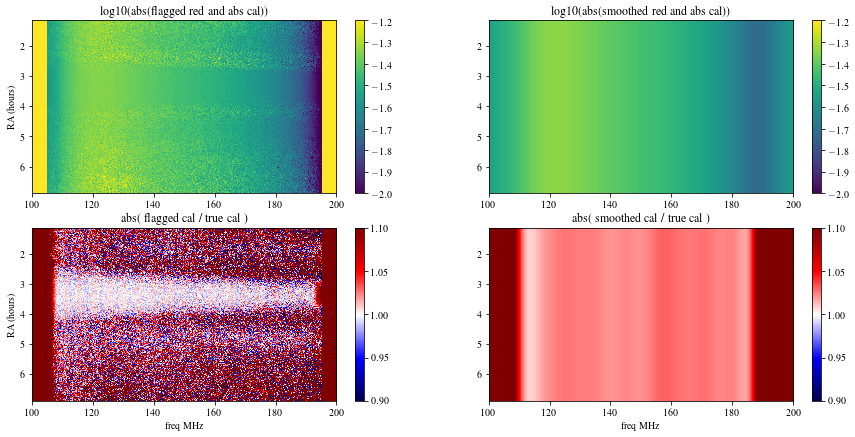

In [201]:
k = (12, 'Jee')
fig, axes = plt.subplots(2, 2, figsize=(15, 7))

ax = axes[0, 0]
cax = ax.imshow(np.log10(np.abs(uvg.get_gains(k))).T, aspect='auto', vmin=-2, vmax=-1.2,
                extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
ax.set_title("log10(abs(flagged red and abs cal))")
fig.colorbar(cax, ax=ax)
ax.set_ylabel('RA (hours)')

ax = axes[0, 1]
cax = ax.imshow(np.log10(np.abs(uvs.get_gains(k))).T, aspect='auto', vmin=-2, vmax=-1.2,
                extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
ax.set_title("log10(abs(smoothed red and abs cal))")
fig.colorbar(cax, ax=ax)

ax = axes[1, 0]
cax = ax.imshow(np.abs(uvg.get_gains(k) / uvt.get_gains(k)).T, aspect='auto', vmin=0.9, vmax=1.1, cmap='seismic',
                extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
ax.set_title('abs( flagged cal / true cal )')
fig.colorbar(cax, ax=ax)
ax.set_xlabel('freq MHz')
ax.set_ylabel('RA (hours)')

ax = axes[1, 1]
cax = ax.imshow(np.abs(uvs.get_gains(k) / uvt.get_gains(k)).T, aspect='auto', vmin=0.9, vmax=1.1, cmap='seismic',
                extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
ax.set_title('abs( smoothed cal / true cal )')
fig.colorbar(cax, ax=ax)
ax.set_xlabel('freq MHz')

__Figure 1__ | Recovered antenna gains compared to the true gains for antenna 12, polarization EE. Left panels show full gains, right panels show smoothed gains (across time and frequency).

invalid value encountered in true_divide


Text(0.5, 1.0, 'time average of smooth cal / true cal')

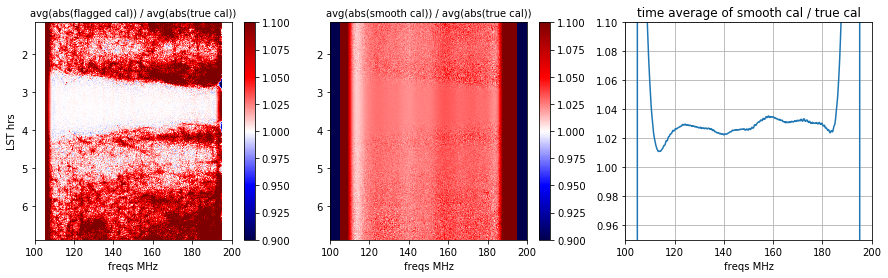

In [41]:
# average ratio
pol = 'Jee'

w = {(a, pol): (~uvg.get_flags((a, pol))).astype(np.float) for a in uvg.ant_array} 
fg = [uvg.get_gains((a, pol)) * w[(a, pol)] for a in uvg.ant_array]
sg = [uvs.get_gains((a, pol)) * w[(a, pol)] for a in uvg.ant_array]
tg = [uvt.get_gains((a, pol)) * w[(a, pol)] for a in uvg.ant_array]
wsum = np.sum(list(w.values()), axis=0).clip(1e-10, np.inf)
rg = np.sum(np.abs(sg) / np.abs(tg).clip(1e-10, np.inf), axis=0) / wsum
fg = np.sum(np.abs(fg), axis=0) / wsum
sg = np.sum(np.abs(sg), axis=0) / wsum
tg = np.sum(np.abs(tg), axis=0) / wsum

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
cax = ax.imshow((fg / tg).T, aspect='auto', cmap='seismic', vmin=0.9, vmax=1.1,
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_title("avg(abs(flagged cal)) / avg(abs(true cal))", fontsize=10)
ax.set_xlabel('freqs MHz')
ax.set_ylabel('LST hrs')

ax = axes[1]
cax = ax.imshow(rg.T, aspect='auto', cmap='seismic', vmin=0.9, vmax=1.1,
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_title("avg(abs(smooth cal)) / avg(abs(true cal))", fontsize=10)
ax.set_xlabel('freqs MHz')

ax = axes[2]
ax.plot(freqs, np.mean(rg, axis=1))
ax.set_xlim(100, 200)
ax.set_ylim(0.95, 1.1)
ax.grid()
ax.set_xlabel('freqs MHz')
ax.set_title("time average of smooth cal / true cal")

__Figure 2__ | Recovered gain amplitude compared to true gain amplitude for EE polarization gains. Left panel is post-calibration gain ratio, middle panel is post-smoothing gain ratio, and right panel is its time average.

invalid value encountered in true_divide


Text(0.5, 1.0, 'time average of smooth cal / true cal')

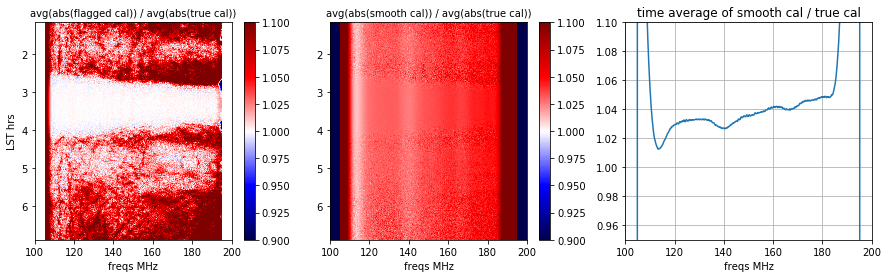

In [43]:
# average ratio
pol = 'Jnn'

w = {(a, pol): (~uvg.get_flags((a, pol))).astype(np.float) for a in uvg.ant_array} 
fg = [uvg.get_gains((a, pol)) * w[(a, pol)] for a in uvg.ant_array]
sg = [uvs.get_gains((a, pol)) * w[(a, pol)] for a in uvg.ant_array]
tg = [uvt.get_gains((a, pol)) * w[(a, pol)] for a in uvg.ant_array]
wsum = np.sum(list(w.values()), axis=0).clip(1e-10, np.inf)
rg = np.sum(np.abs(sg) / np.abs(tg).clip(1e-10, np.inf), axis=0) / wsum
fg = np.sum(np.abs(fg), axis=0) / wsum
sg = np.sum(np.abs(sg), axis=0) / wsum
tg = np.sum(np.abs(tg), axis=0) / wsum

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
cax = ax.imshow((fg / tg).T, aspect='auto', cmap='seismic', vmin=0.9, vmax=1.1,
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_title("avg(abs(flagged cal)) / avg(abs(true cal))", fontsize=10)
ax.set_xlabel('freqs MHz')
ax.set_ylabel('LST hrs')

ax = axes[1]
cax = ax.imshow(rg.T, aspect='auto', cmap='seismic', vmin=0.9, vmax=1.1,
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_title("avg(abs(smooth cal)) / avg(abs(true cal))", fontsize=10)
ax.set_xlabel('freqs MHz')

ax = axes[2]
ax.plot(freqs, np.mean(rg, axis=1))
ax.set_xlim(100, 200)
ax.set_ylim(0.95, 1.1)
ax.grid()
ax.set_xlabel('freqs MHz')
ax.set_title("time average of smooth cal / true cal")

__Figure 3__ | Recovered gain amplitude compared to true gain amplitude for EE polarization gains. Left panel is post-calibration gain ratio, middle panel is post-smoothing gain ratio, and right panel is its time average.

invalid value encountered in true_divide


Text(0.5, 1.0, 'time average of smooth cal / true cal')

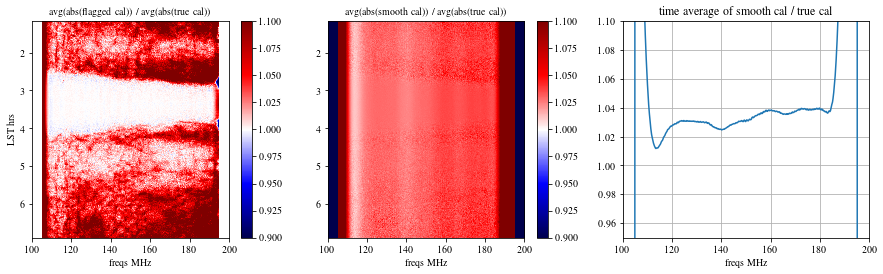

In [217]:
# average ratio
w = {(a): (~uvg.get_flags(a)).astype(np.float) for a in uvg.ant_array} 
fg = [uvg.get_gains((a)) * w[(a)] for a in uvg.ant_array]
sg = [uvs.get_gains((a)) * w[(a)] for a in uvg.ant_array]
tg = [uvt.get_gains((a)) * w[(a)] for a in uvg.ant_array]
wsum = np.sum(list(w.values()), axis=(0,3)).clip(1e-10, np.inf)
rg = np.sum(np.abs(sg) / np.abs(tg).clip(1e-10, np.inf), axis=(0, 3)) / wsum
fg = np.sum(np.abs(fg), axis=(0, 3)) / wsum
sg = np.sum(np.abs(sg), axis=(0, 3)) / wsum
tg = np.sum(np.abs(tg), axis=(0, 3)) / wsum

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
cax = ax.imshow((fg / tg).T, aspect='auto', cmap='seismic', vmin=0.9, vmax=1.1,
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_title("avg(abs(flagged cal)) / avg(abs(true cal))", fontsize=10)
ax.set_xlabel('freqs MHz')
ax.set_ylabel('LST hrs')

ax = axes[1]
cax = ax.imshow(rg.T, aspect='auto', cmap='seismic', vmin=0.9, vmax=1.1,
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_title("avg(abs(smooth cal)) / avg(abs(true cal))", fontsize=10)
ax.set_xlabel('freqs MHz')

ax = axes[2]
ax.plot(freqs, np.mean(rg, axis=1))
ax.set_xlim(100, 200)
ax.set_ylim(0.95, 1.1)
ax.grid()
ax.set_xlabel('freqs MHz')
ax.set_title("time average of smooth cal / true cal")

__Figure 4__ | Same as 2 and 3 but having averaged over both polarizations.

# 2. Flag Inpainting <a class="anchor" id="inpaint"></a>

Here we show some basic results from inpainting, showing that RFI flags are deconvolved down to the cross correlation noise floor for a subset of the data.

In [46]:
dstem = "/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/"
lfiles = sorted(glob.glob(dstem + "zen.grp1.of1.LST.*.HH.OCRSL.uvh5"))
pfiles = sorted(glob.glob(dstem + "zen.grp1.of1.LST.*.HH.OCRSLP.uvh5"))

In [63]:
uvd = UVData()
uvd.read(pfiles[0], read_data=False)
reds, lens, angs = hp.utils.get_reds(uvd, pick_data_ants=True, bl_len_range=(10, 20))
bls = reds[-1]

In [67]:
L = hc.frf.FRFilter(lfiles[4:14])
L.read(bls=bls + [(36, 36)], polarizations=['ee', 'nn'], )

In [68]:
P = hc.frf.FRFilter(pfiles[4:14])
P.read(bls=bls + [(36, 36)], polarizations=['ee', 'nn'], )

In [71]:
# print parameters
history = P.hd.history
hind = P.hd.history.find('Ran preprocess_data.py fg filt step')
print(history[history.find("preprocess_data.py fg filt"):history.find('freq_avg_min_nsamp')+23])

preprocess_data.py fg filt step at
UTC 2020-08-18 01:05:31.602022 with 
hera_pspec [105ddb69b9], hera_cal [49165f5a0d],
hera_qm [876f3f3c42] and pyuvdata [67eca3a770]
with fg filt algorithm parameters
resid_ext : None
inpaint_ext : P
axis : freq
clean_params : {'standoff': 50.0, 'horizon': 1.0, 'min_dly': 2000.0, 'tol': 1e-05, 'autotol': 5e-07, 'maxiter': 100, 'window': 'tukey', 'alpha': 0.15, 'skip_wgt': 0.2, 'gain': 0.9, 'edgecut_low': 100, 'edgecut_hi': 150, 'zeropad': 256, 'max_frate': 3.0}
trim_model : False
noise_thresh : 2.0
delay_cut : 2000
kernel_size : None
polyfit_deg : None
flag_lsts : [(0.9, 1.0)]
flag_chans : [(135, 136), (169, 171), (424, 425), (570, 573), (697, 698), (815, 816)]
freq_avg_min_nsamp : 5



Text(0.5, 1.0, 'visibility amplitude')

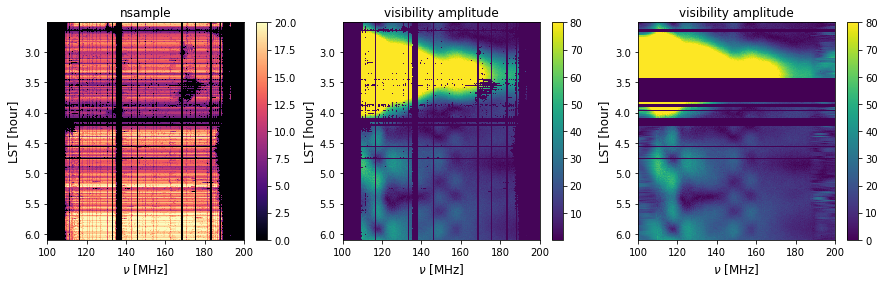

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
cax = ax.imshow(P.nsamples[(12, 13, 'ee')], aspect='auto', cmap='magma', vmax=20,
                extent=[P.freqs[0]/1e6, P.freqs[-1]/1e6, P.lsts[-1]*12/np.pi, P.lsts[0]*12/np.pi])
cbar = fig.colorbar(cax, ax=ax)
ax.set_xlabel(r"$\nu$ [MHz]", fontsize=12); ax.set_ylabel('LST [hour]', fontsize=12)
ax.set_title("nsample", fontsize=12)

ax = axes[1]
cax = ax.imshow(np.abs(L.data[(12, 13, 'ee')]), aspect='auto', cmap='viridis', vmax=80,
                extent=[P.freqs[0]/1e6, P.freqs[-1]/1e6, P.lsts[-1]*12/np.pi, P.lsts[0]*12/np.pi])
cbar = fig.colorbar(cax, ax=ax)
ax.set_xlabel(r"$\nu$ [MHz]", fontsize=12); ax.set_ylabel('LST [hour]', fontsize=12)
ax.set_title("visibility amplitude", fontsize=12)

ax = axes[2]
cax = ax.imshow(np.abs(P.data[(12, 13, 'ee')]), aspect='auto', cmap='viridis', vmax=80,
                extent=[P.freqs[0]/1e6, P.freqs[-1]/1e6, P.lsts[-1]*12/np.pi, P.lsts[0]*12/np.pi])
cbar = fig.colorbar(cax, ax=ax)
ax.set_xlabel(r"$\nu$ [MHz]", fontsize=12); ax.set_ylabel('LST [hour]', fontsize=12)
ax.set_title("visibility amplitude", fontsize=12)

__Figure 5__ | Nsample count after LST binning (left), post-LSTbin visibility amplitude (center), and post-inpaint visibility amplitude (right). Some LSTs after Fornax A transit are completely flagged due to low nsample and odd behavior of RFI mask near 170 MHz.

In [137]:
P.timeavg_data(P.data, P.times, P.lsts, 60 * 1, flags=P.flags, wgt_by_nsample=False,
               rephase=True, overwrite=True, verbose=False)
L.timeavg_data(L.data, L.times, L.lsts, 60 * 1, flags=L.flags, wgt_by_nsample=False,
               rephase=True, overwrite=True, verbose=False)

In [138]:
P.fft_data(data=P.avg_data, edgecut_low=500, edgecut_hi=1024-800, overwrite=True, window='bh')
L.fft_data(data=L.avg_data, edgecut_low=500, edgecut_hi=1024-800, overwrite=True, window='bh')

divide by zero encountered in log10
divide by zero encountered in log10


Text(0.5, 1.0, '$\\log_{10} |\\widetilde{V}_{\\rm cross}|$')

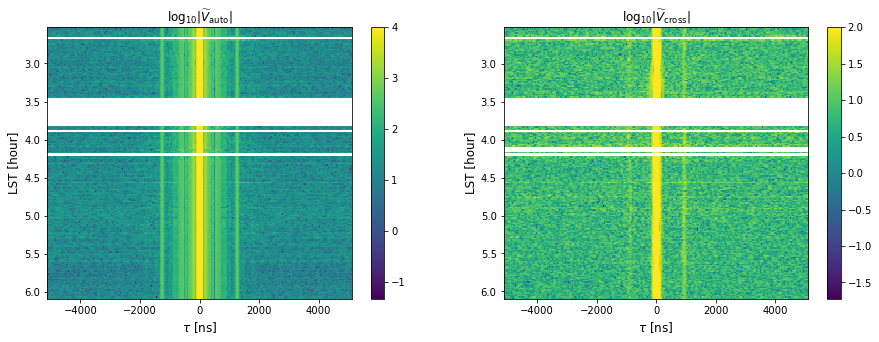

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
k = (36, 36, 'ee')
cax = ax.imshow(np.log10(np.abs(P.dfft[k])), aspect='auto', cmap='viridis', vmax=4,
                extent=[P.delays[0], P.delays[-1], P.avg_lsts[-1]*12/np.pi, P.avg_lsts[0]*12/np.pi])
cbar = fig.colorbar(cax, ax=ax)
ax.set_xlabel(r"$\tau$ [ns]", fontsize=12); ax.set_ylabel('LST [hour]', fontsize=12)
ax.set_title(r"$\log_{10} |\widetilde{V}_{\rm auto}|$", fontsize=12)

ax = axes[1]
k = (12, 13, 'ee')
cax = ax.imshow(np.log10(np.abs(P.dfft[k])), aspect='auto', cmap='viridis', vmax=2,
                extent=[P.delays[0], P.delays[-1], P.lsts[-1]*12/np.pi, P.lsts[0]*12/np.pi])
cbar = fig.colorbar(cax, ax=ax)
ax.set_xlabel(r"$\tau$ [ns]", fontsize=12); ax.set_ylabel('LST [hour]', fontsize=12)
ax.set_title(r"$\log_{10} |\widetilde{V}_{\rm cross}|$", fontsize=12)

__Figure 6__ | Waterfall of auto (left) and cross correlation (right) visibilities in delay space after inpainting. Delays above 2000 ns appear noise-like, which is a good check on the inpainting performance.

Text(0.5, 1.0, 'time and baseline averaged cross correlation')

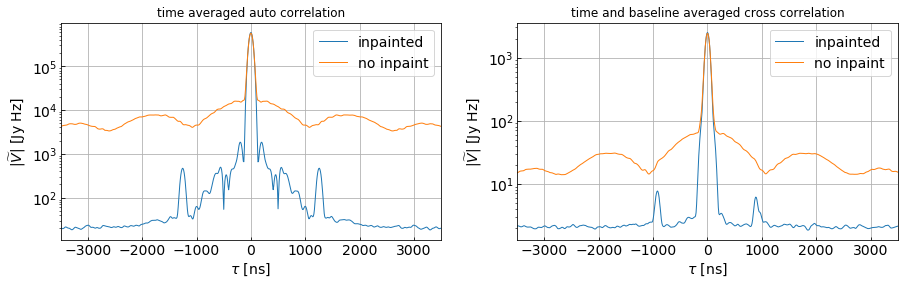

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
xlim = (-3500, 3500)

ax = axes[0]
ax.tick_params(labelsize=14, direction='in')
k = (36, 36, 'ee')
ax.plot(P.delays, np.mean(np.abs(P.dfft[k][~P.avg_flags[k][:,0]]), axis=0), lw=1, label='inpainted')
ax.plot(L.delays, np.mean(np.abs(L.dfft[k][~P.avg_flags[k][:,0]]), axis=0), lw=1, label='no inpaint')
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r'$\tau$ [ns]', fontsize=14);ax.set_ylabel(r'$|\widetilde{V}|$ [Jy Hz]', fontsize=14)
ax.legend(fontsize=14)
ax.set_xlim(xlim)
ax.set_title("time averaged auto correlation")

# average cross correlations from the redundant group
wd, pd, ld = [], [], []
for k in bls:
    key = k + ('ee',)
    w = (~P.avg_flags[key]).astype(np.float)
    wd.append(w)
    pd.append(P.dfft[key] * w)
    ld.append(L.dfft[key] * w)
wsum = np.sum(wd, axis=0)
fsum = np.isclose(wsum, 0)
pd = np.sum(pd, axis=0) / wsum.clip(1e-40, np.inf)
ld = np.sum(ld, axis=0) / wsum.clip(1e-40, np.inf)

ax = axes[1]
ax.tick_params(labelsize=14, direction='in')
ax.plot(P.delays, np.mean(np.abs(pd[~fsum[:, 0]]), axis=0), lw=1, label='inpainted')
ax.plot(P.delays, np.mean(np.abs(ld[~fsum[:, 0]]), axis=0), lw=1, label='no inpaint')
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r'$\tau$ [ns]', fontsize=14);ax.set_ylabel(r'$|\widetilde{V}|$ [Jy Hz]', fontsize=14)
ax.legend(fontsize=14)
ax.set_xlim(xlim)
ax.set_title("time and baseline averaged cross correlation")

__Figure 7__ | Comparing the non-inpainted (orange) to the inpainted data after time averaging. The non-inpainted dataset shows large sidelobes from the RFI at high delay, while the inpainted dataset shows a nice transition to a delay-indepenent noise floor at high delays. The left panel shows a single auto-correlation, the right panel shows the average of all East-West 14.6-m baselines.

# 3. Reflection Calibration <a class="anchor" id="ref-cal"></a>

Here we plot the output from reflection calibration. Reflection calibration is performed independently over two spectral windows, spanning channels 100 -- 400, and 400 -- 874.

In [218]:
dstem = "/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/"
dfiles = sorted(glob.glob(dstem + "zen.grp1.of1.LST.*.HH.OCRSLP.uvh5"))

In [219]:
F = hc.frf.FRFilter(dfiles[4:14])
F.read(bls=[(13, 13), (12, 12), (12, 13)], polarizations=['ee', 'nn'])

In [220]:
cfiles = sorted(glob.glob(dstem + "zen.grp1.of1.LST.*.HH.OCRSLP.allspws.refcal_smooth.calfits"))

In [221]:
uvc = hc.io.HERACal(cfiles[4:14])
gains, gflags, _, _ = uvc.read()

In [222]:
# reflection cal params
print(uvc.history[:760])



Ran preprocess_data.py reflection calibration step at
UTC 2020-09-18 15:56:36.712909 with
hera_pspec [105ddb69b9], hera_cal [],
hera_qm [] and pyuvdata [2.1.2.dev78+geb611ba.main]
on data_template /lustre/aoc/projects/hera/Validation/test-4.0.0/pipelin
e/LSTBIN/sum/zen.grp1.of1.LST.*.*.HH.OCRSLP.uvh5
with reflection calibration algorithm parameters

cal_ext : refcal.calfits
time_avg : True
expand_times : True
wgt_by_nsample : False
dly_ranges : [(75, 800, 3), (100, 800, 5), (200, 800, 5), (250, 800, 5),
 (300, 800, 5), (700, 1500, 5)]
window : bh
alpha : 0.1
edgecut_low : [100, 400]
edgecut_hi : [524, 150]
combine_spws : True
spw_boundaries : [(100, 400), (400, 874)]
zeropad : 256
Nphs : 100
fthin : None
ref_sig_cut : 1.0
opt_maxiter : 0
opt_buffer


In [223]:
F.cdata = copy.deepcopy(F.data)
hc.apply_cal.calibrate_in_place(F.cdata, gains, data_flags=F.flags, cal_flags=gflags)

In [224]:
F.timeavg_data(F.data, F.times, F.lsts, 60*5, flags=F.flags, wgt_by_nsample=False, rephase=True,
               overwrite=True, output_prefix='avg', verbose=False)
F.timeavg_data(F.cdata, F.times, F.lsts, 60*5, flags=F.flags, wgt_by_nsample=False, rephase=True,
               overwrite=True, output_prefix='cavg', verbose=False)

In [225]:
F.fft_data(data=F.avg_data, edgecut_low=515, edgecut_hi=1024-695, overwrite=True, window='bh', assign='dfft')
F.fft_data(data=F.cavg_data, edgecut_low=515, edgecut_hi=1024-695, overwrite=True, window='bh', assign='cfft')

Text(0.5, 0, '$\\tau$ [ns]')

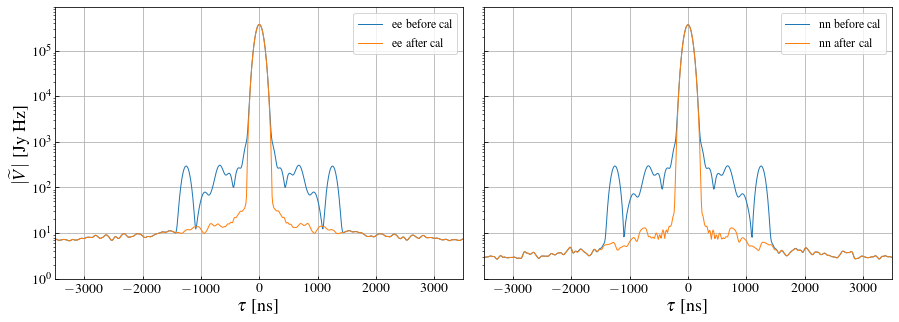

In [226]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.05)

xlim = -3500, 3500
ylim = 1e0, 9e5

ax = axes[0]
ax.tick_params(labelsize=14, direction='in')
k = (12, 12, 'ee')
ax.plot(F.delays, np.mean(np.abs(F.dfft[k][~F.avg_flags[k][:,0]]), axis=0), lw=1, label='ee before cal')
ax.plot(F.delays, np.mean(np.abs(F.cfft[k][~F.avg_flags[k][:,0]]), axis=0), lw=1, label='ee after cal')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.grid()
ax.legend(fontsize=12, ncol=1)
ax.set_xlabel(r'$\tau$ [ns]', fontsize=18)
ax.set_ylabel(r'$|\widetilde{V}|$ [Jy Hz]', fontsize=18)

ax = axes[1]
ax.tick_params(labelsize=14, direction='in')
k = (12, 12, 'nn')
ax.plot(F.delays, np.mean(np.abs(F.dfft[k][~F.avg_flags[k][:,0]]), axis=0), lw=1, label='nn before cal')
ax.plot(F.delays, np.mean(np.abs(F.cfft[k][~F.avg_flags[k][:,0]]), axis=0), lw=1, label='nn after cal')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticklabels([])
ax.grid()
ax.legend(fontsize=12, ncol=1)
ax.set_xlabel(r'$\tau$ [ns]', fontsize=18)

__Figure 8__ | Auto-correlation from a single antenna before (blue) and after reflection calibration for the EE (left) and NN polarization (right). Reflection systematics are suppressed by about a factor of 30 in the simulated visibilities.

Text(0.5, 0, '$\\tau$ [ns]')

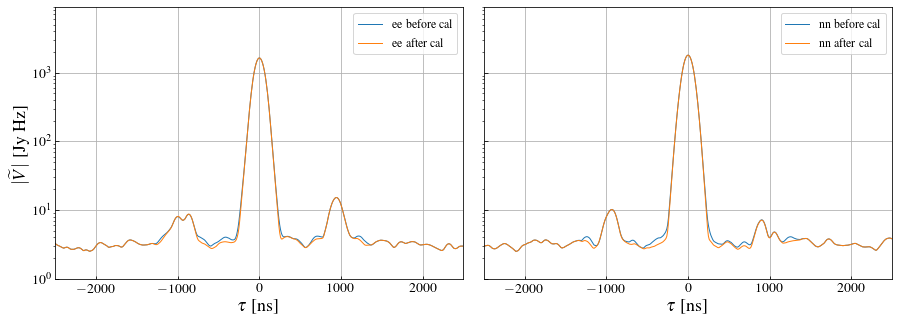

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.05)

xlim = -2500, 2500
ylim = 1e0, 9e3

ax = axes[0]
ax.tick_params(labelsize=14, direction='in')
k = (12, 13, 'ee')
ax.plot(F.delays, np.mean(np.abs(F.dfft[k][~F.avg_flags[k][:,0]]), axis=0), lw=1, label='ee before cal')
ax.plot(F.delays, np.mean(np.abs(F.cfft[k][~F.avg_flags[k][:,0]]), axis=0), lw=1, label='ee after cal')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.grid()
ax.legend(fontsize=12, ncol=1)
ax.set_xlabel(r'$\tau$ [ns]', fontsize=18)
ax.set_ylabel(r'$|\widetilde{V}|$ [Jy Hz]', fontsize=18)

ax = axes[1]
ax.tick_params(labelsize=14, direction='in')
k = (12, 13, 'nn')
ax.plot(F.delays, np.mean(np.abs(F.dfft[k][~F.avg_flags[k][:, 0]]), axis=0), lw=1, label='nn before cal')
ax.plot(F.delays, np.mean(np.abs(F.cfft[k][~F.avg_flags[k][:,0]]), axis=0), lw=1, label='nn after cal')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticklabels([])
ax.grid()
ax.legend(fontsize=12, ncol=1)
ax.set_xlabel(r'$\tau$ [ns]', fontsize=18)

__Figure 9__ | Cross correlation visibilities before (blue) and after (orange) reflection calibration. The major systematics at +/- 1000 ns is cross coupling, so we don't expect refcal to mitigate those features, however at intermediate delays we can begin see hints of reflection systematic suppresion before the noise floor dominates.

# 4. Crosstalk Filtering <a class="anchor" id="xtalk"></a>

In [503]:
dstem = "/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/"
dfiles = sorted(glob.glob(dstem + "zen.grp1.of1.LST.*.HH.OCRSLP.uvh5"))
xfiles = sorted(glob.glob(dstem + "zen.grp1.of1.LST.*.HH.OCRSLPX.uvh5"))

In [229]:
cfiles = [df.replace('uvh5', 'allspws.refcal_smooth.calfits') for df in dfiles]

In [464]:
uvc = hc.io.HERACal(cfiles)
gains, gflags, _, _ = uvc.read()

In [487]:
P = hc.reflections.ReflectionFitter(dfiles)
P.read(bls=[(12, 13), (12, 12), (36, 38), (36, 39)], polarizations=['ee', 'nn'])

In [488]:
P.cdata = copy.deepcopy(P.data)
hc.apply_cal.calibrate_in_place(P.cdata, gains, data_flags=P.flags, cal_flags=gflags)

In [504]:
X = hc.reflections.ReflectionFitter(xfiles)
X.read(bls=[(12, 13), (12, 12), (36, 38), (36, 39)], polarizations=['ee', 'nn'])

In [505]:
start = X.hd.history.find('Ran preprocess_data.py xtalk sub')
print(X.hd.history[start:start+775])

Ran preprocess_data.py xtalk sub step at
UTC 2020-09-18 16:08:24.355602 with 
hera_pspec [105ddb69b9], hera_cal [],
hera_qm [] and pyuvdata [2.1.2.dev78+geb611ba.main]
on data_template /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.*.*.HH.OCRSLP.uvh5
with xtalk sub algorithm parameters

file_ext : X
Nbl_per_task : 10
method : svd-gp
max_frate_coeffs : [0.024, -0.229]
min_dly : 100
max_dly : 4000
horizon : 0.8
standoff : 0
window : bh
alpha : 0.1
edgecut_low : [100, 400]
edgecut_hi : [624, 150]
gp_frate_degrade : 0.0
gp_Nmirror : 200
Nkeep : 30
xthin : None
project_vmodes : False
frate_thresh : 0.1
rm_intermediate_files : False
tol : 1e-08

and calibration zen.grp1.of1.LST.0.28190.HH.OCRSLP.allspws.refcal_smooth.calfits history:


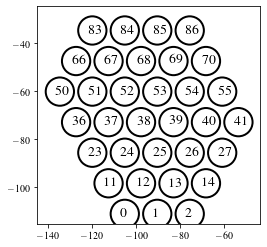

In [234]:
antpos, ants = P.hd.get_ENU_antpos()

plt.figure(figsize=(4, 4))
for i, a in enumerate(ants):
    plt.scatter(antpos[i,0], antpos[i,1], s=800, fc='None', ec='k', lw=2)
    plt.text(antpos[i,0]-2, antpos[i,1]-1, a, fontsize=14)

In [506]:
max_frate = {}
for k in P.data.keys():
    max_frate[k] = max([0, np.polyval([0.024, -0.229], abs(P.blvecs[k[:2]][0]))])

Text(0.5, 1.0, 'Xtalk Model')

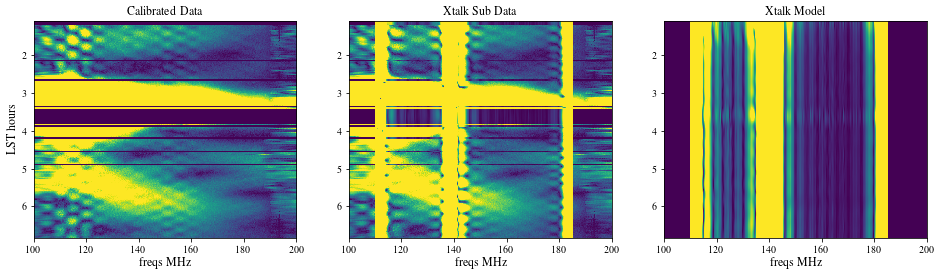

In [508]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
key = (36, 38, 'ee')

ax = axes[0]
ax.imshow(np.abs(P.cdata[key]), aspect='auto', vmax=30,
          extent=[P.freqs[0]/1e6, P.freqs[-1]/1e6, P.lsts[-1]*12/np.pi, P.lsts[0]*12/np.pi])
ax.set_xlabel('freqs MHz', fontsize=12)
ax.set_ylabel('LST hours', fontsize=12)
ax.set_title("Calibrated Data", fontsize=12)

ax = axes[1]
ax.imshow(np.abs(X.data[key]), aspect='auto', vmax=30,
          extent=[P.freqs[0]/1e6, P.freqs[-1]/1e6, P.lsts[-1]*12/np.pi, P.lsts[0]*12/np.pi])
ax.set_xlabel('freqs MHz', fontsize=12)
ax.set_title("Xtalk Sub Data", fontsize=12)

ax = axes[2]
ax.imshow(np.abs(P.cdata[key] - X.data[key]), aspect='auto', vmax=10,
          extent=[P.freqs[0]/1e6, P.freqs[-1]/1e6, P.lsts[-1]*12/np.pi, P.lsts[0]*12/np.pi])
ax.set_xlabel('freqs MHz', fontsize=12)
ax.set_title("Xtalk Model", fontsize=12)

__Figure 10__ | Xtalk filtering on a 14.6m East-West baseline. The bandpass and reflection calibrated visibility amplitude (left), after xtalk subtraction (middle) and the xtalk model (right). The xtalk model is broken into two spectral windows at the low band (110-140 MHz) and the mid band (140 - 185 MHz), giving rise to the bright features near the spw boundaries.

In [509]:
P.timeavg_data(P.data, P.times, P.lsts, P.dtime * 5, flags=P.flags, wgt_by_nsample=False, rephase=True,
               overwrite=True, verbose=False)
P.timeavg_data(P.cdata, P.times, P.lsts, P.dtime * 5, flags=P.flags, wgt_by_nsample=False, rephase=True,
               overwrite=True, verbose=False,
               output_prefix='cavg')
X.timeavg_data(X.data, X.times, X.lsts, P.dtime * 5, flags=P.flags, wgt_by_nsample=False, rephase=True,
               overwrite=True, verbose=False)

In [510]:
avg_times = P.avg_times * 24 * 3600
avg_dtime = np.diff(avg_times).mean()
P.vis_clean(data=P.avg_data, flags=P.avg_flags, ax='time', max_frate=5, tol=1e-5, gain=0.9,
            window='bh', alpha=0.1, overwrite=True, verbose=False, x=avg_times)
P.vis_clean(data=P.cavg_data, flags=P.cavg_flags, ax='time', max_frate=5, tol=1e-5, gain=0.9,
            window='bh', alpha=0.1, overwrite=True, verbose=False, output_prefix='cclean', x=avg_times)
X.vis_clean(data=X.avg_data, flags=X.avg_flags, ax='time', max_frate=5, tol=1e-5, gain=0.9,
            window='bh', alpha=0.1, overwrite=True, verbose=False, x=avg_times)

In [535]:
el = (85, 515)
eh = (0, 1024 - 695)

P.fft_data(data=P.clean_data, window='bh', edgecut_low=el[1], edgecut_hi=eh[1], overwrite=True, assign='dfft')
P.fft_data(data=P.cclean_data, window='bh', edgecut_low=el[1], edgecut_hi=eh[1], overwrite=True, assign='cfft')
X.fft_data(data=X.clean_data, window='bh', edgecut_low=el[1], edgecut_hi=eh[1], overwrite=True, assign='dfft')

P.fft_data(data=P.clean_data, window=('bh','bh'), ax='both', edgecut_low=el, edgecut_hi=eh,
           overwrite=True, assign='dfft2', dtime=avg_dtime)
P.fft_data(data=P.cclean_data, window=('bh','bh'), ax='both', edgecut_low=el, edgecut_hi=eh,
           overwrite=True, assign='cfft2', dtime=avg_dtime)
X.fft_data(data=X.clean_data, window=('bh','bh'), ax='both', edgecut_low=el, edgecut_hi=eh,
           overwrite=True, assign='dfft2', dtime=avg_dtime)

max frate: 0.8


Text(0.5, 1.0, 'LSTBinned Data + RefCal + Xtalk Sub')

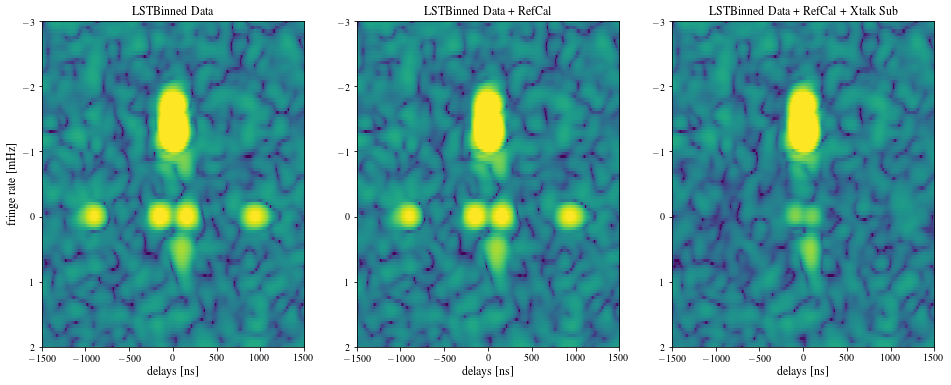

In [536]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
key = (36, 39, 'ee')
xlim = -1500, 1500
ylim = 2, -3

max_frate_coeffs = [0.024, -0.229]
max_frate = max([0, np.polyval(max_frate_coeffs, abs(P.blvecs[key[:2]][0]))])
print("max frate: {:.1f}".format(max_frate))

ax = axes[0]
cax = ax.imshow(np.log10(np.abs(P.dfft2[key])), aspect='auto', vmin=0, vmax=3,
                extent=[P.delays[0], P.delays[-1], P.frates[-1], P.frates[0]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('delays [ns]', fontsize=12)
ax.set_ylabel('fringe rate [mHz]', fontsize=12)
ax.set_title("LSTBinned Data", fontsize=12)

ax = axes[1]
cax = ax.imshow(np.log10(np.abs(P.cfft2[key])), aspect='auto', vmin=0, vmax=3,
                extent=[X.delays[0], X.delays[-1], X.frates[-1], X.frates[0]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('delays [ns]', fontsize=12)
ax.set_title("LSTBinned Data + RefCal", fontsize=12)

ax = axes[2]
cax = ax.imshow(np.log10(np.abs(X.dfft2[key])), aspect='auto', vmin=0, vmax=3,
                extent=[X.delays[0], X.delays[-1], X.frates[-1], X.frates[0]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('delays [ns]', fontsize=12)
ax.set_title("LSTBinned Data + RefCal + Xtalk Sub", fontsize=12)

__Figure 11__ | A East-West visibility in fringe rate and delay space, before reflection calibration (left), after reflection calibration (middle) and after xtalk subtraction (right).

# 5. Power Spectrum Estimation <a class="anchor" id="pspec"></a>

In [4]:
def wedge_plot(u, ax, vmin=5, vmax=14, loglog=True, log10=True, fold=True, xlim=(5.0e-3, 6.1e-2), cmap='Spectral_r',
               ylim=(1.5e-2, 2.8e0), polpair=('pI', 'pI'), cbax=None, bl_label=True, dly_label=True, red_tol=0.1,
               component='real', spw=0):
    mean_freq = np.mean(u.get_spw_ranges(spw)[0][:2])
    z = u.cosmo.f2z(mean_freq)
    t2k = u.cosmo.tau_to_kpara(z, little_h=True) / 1e9

    hp.plot.delay_wedge(u, spw, polpair, log10=log10, ax=ax, fold=fold, rotate=True,
                        horizon_lines=False, red_tol=red_tol, colorbar=cbax is not None,
                        cbax=cbax, vmin=vmin, vmax=vmax, cmap=cmap, delay=False,
                        loglog=loglog, component=component)
    ax.tick_params(labelsize=16, size=8, direction='in', width=1, pad=10)
    ax.tick_params(which='minor', size=4, direction='in', width=1)
    if cbax is not None:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)

    x = np.linspace(5, 140, 100)
    k = x * uvp.cosmo.bl_to_kperp(z)
    y = x / 2.99e8 * t2k * 1e9
    ax.plot(k, y + .0, color='grey', ls='--', lw=2.5)
    #ax.plot(k, y + np.diff(uvp.dly_array)[0] * 1e9 * t2k * 2, color='w', ls='--', lw=3)
    #ax.text(5.2e-3, 0.9e-1, "horizon", fontsize=18, rotation=0, c='w')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$k_{\perp}\ [h\ {\rm Mpc}^{-1}$]', fontsize=20)
    ax.set_ylabel(r'$k_{\parallel}\ [h\ {\rm Mpc}^{-1}$]', fontsize=20)

    ax2 = ax.twiny()
    if loglog:
        ax2.set_xscale('log')
    ax2.set_xlim(*np.array(ax.get_xlim()) / uvp.cosmo.bl_to_kperp(z))
    ax2.tick_params(which='major', length=8, direction='in', width=1, labelsize=16)
    ax2.tick_params(which='minor', length=4, direction='in', width=1)
    if bl_label:
        ax2.set_xlabel(r"$|b|$ [meters]", fontsize=20, labelpad=10)
    else:
        ax2.set_xticklabels([])

    ax3 = ax.twinx()
    if loglog:
        ax3.set_yscale('log')
    ax3.set_ylim(*np.array(ax.get_ylim()) / t2k)
    ax3.tick_params(which='major', length=8, direction='in', width=1, labelsize=16)
    ax3.tick_params(which='minor', length=4, direction='in', width=1)
    if dly_label:
        ax3.set_ylabel(r"$\tau$ [nanosec]", fontsize=20, labelpad=10)
    else:
        ax3.set_yticklabels([])
        
    return ax2, ax3

In [5]:
def load_red_uvps(psc, groupname, **kwargs):
    # load baselines w/ proj EW len > 14m
    spec = np.array([sp for sp in psc.spectra(groupname) if sp[-5:] == 'dset1'])
    lens, angs = [float(sp[:3]) for sp in spec], [float(sp[5:8]) for sp in spec]
    proj_lens = [np.abs(l*np.cos(a*np.pi/180)) for l, a in zip(lens, angs)]
    keep = [i for i in range(len(proj_lens)) if (proj_lens[i] >= 14) and (lens[i] < 120)]
    uvps = [psc.get_pspec(groupname, sp, **kwargs) for sp in spec[keep]]
    # fill nans
    for uvp in uvps:
        for spw in uvp.data_array:
            uvp.data_array[spw][np.isnan(uvp.data_array[spw])] = 0
    lens = [lens[i] for i in keep]
    angs = [angs[i] for i in keep]
    Nbls = [uvp.Nblpairs for uvp in uvps]
    # print contents
    print("\n"+"-"*40+"\n"+os.path.basename(psc.filename))
    pandas.options.display.float_format = '{:.1f}'.format
    display(pandas.DataFrame([np.around(lens,1), angs, Nbls], index=['length [m]', 'angle [deg]', "Nblpairs"]))
    return uvps

In [6]:
def red_avg(uvps, exclude_autos=True, exclude_cross=False, **kwargs):
    uvps_avg = []
    for uvp in uvps:
        blps = uvp.get_blpairs()
        if exclude_autos:
            blps = [blp for blp in blps if blp[0] != blp[1]]
        if exclude_cross:
            blps = [blp for blp in blps if blp[0] == blp[1]]
        if len(blps) > 0:
            u = uvp.select(blpairs=blps, inplace=False)
            uvps_avg.append(u.average_spectra(blpair_groups=[u.get_blpairs()], inplace=False, **kwargs))
    if len(uvps_avg) > 1:
        return hp.uvpspec.combine_uvpspec(uvps_avg, merge_history=False, verbose=False)
    else:
        return uvps_avg[0]

In [7]:
def get_k_nyquist(uvp, spw=0):
    keys = uvp.get_all_keys()
    dly = uvp.get_dlys(spw)
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]
        tau_nyquist = np.amax(dly) + ddly/2.
    spw_freqs = uvp.freq_array[uvp.spw_freq_array == spw]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    return np.amax(tau_nyquist) * uvp.cosmo.tau_to_kpara(z_mean, little_h=True)

def aliased_power_spectrum(k, k_nyquist, z, cosmo, freq_dep=False):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6 * A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k /(2*k_nyquist)))**2
    if freq_dep:
        # assume we're working with the power spectrum w/ frequency-scaled amplitude
        # so follow the steps in the 0.2.0 notebook
        # frequency of HI line at the source
        f21_emit = 1420.4057517667 # MHz
        # redshifted 21-cm line
        f21_obs = f21_emit/(1 + z)
        # scale the power spectrum by an overall factor of 10000
        # (visibilities are scaled by a factor of 100)
        # also apply frequency dependence
        Pk *= 100**2 * (100 / f21_obs)**6
    return Pk * cosmo.h / (1 + z)**2

def get_analytic_spectrum(uvp, spw, freq_dep=False):
    # Get redshift of band center for scaling the aliased spectrum
    freq_range = uvp.get_spw_ranges(spw)[0][:2]
    center = (freq_range[0] + freq_range[1]) / 2
    z = 1420405751.7667 / center - 1
    k_paras = uvp.get_kparas(spw)
    k_nyquist = get_k_nyquist(uvp, spw=spw)
    return aliased_power_spectrum(k_paras, k_nyquist, z, uvp.cosmo, freq_dep)

In [57]:
# see appendix C for details on this
abscal_corr = [1.1167, 1.147]

In [9]:
# load sum
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_corrupt_sum.h5", keep_open=False)
uvps_sum = load_red_uvps(psc, 'stokespol')

# this is true sum: no noise or systematics
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_true_sum.h5", keep_open=False)
uvps_tsum = load_red_uvps(psc, 'stokespol')

# this is with systematic removal
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_corrupt_sum_systematics_removed.h5", keep_open=False)
uvps_rm = load_red_uvps(psc, 'stokespol')

# this is EoR-only
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_eor_PTK.h5", keep_open=False)
uvps_eor = load_red_uvps(psc, 'stokespol')


----------------------------------------
pspec_corrupt_sum.h5


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
length [m],15.0,25.0,25.0,29.0,29.0,29.0,39.0,39.0,39.0,39.0,...,67.0,67.0,67.0,73.0,74.0,76.0,78.0,78.0,78.0,78.0
angle [deg],180.0,30.0,150.0,60.0,120.0,180.0,19.0,41.0,139.0,161.0,...,109.0,131.0,169.0,180.0,120.0,150.0,79.0,101.0,139.0,161.0
Nblpairs,169.0,121.0,100.0,100.0,81.0,121.0,36.0,64.0,81.0,64.0,...,9.0,9.0,9.0,1.0,9.0,4.0,1.0,1.0,4.0,1.0



----------------------------------------
pspec_true_sum.h5


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
length [m],15.0,25.0,25.0,29.0,29.0,29.0,39.0,39.0,39.0,39.0,...,67.0,67.0,67.0,73.0,74.0,76.0,78.0,78.0,78.0,78.0
angle [deg],180.0,30.0,150.0,60.0,120.0,180.0,19.0,41.0,139.0,161.0,...,109.0,131.0,169.0,180.0,120.0,150.0,79.0,101.0,139.0,161.0
Nblpairs,169.0,121.0,100.0,100.0,81.0,121.0,36.0,64.0,81.0,64.0,...,9.0,9.0,9.0,1.0,9.0,4.0,1.0,1.0,4.0,1.0



----------------------------------------
pspec_corrupt_sum_systematics_removed.h5


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
length [m],15.0,25.0,25.0,29.0,29.0,29.0,39.0,39.0,39.0,39.0,...,67.0,67.0,67.0,73.0,74.0,76.0,78.0,78.0,78.0,78.0
angle [deg],180.0,30.0,150.0,60.0,120.0,180.0,19.0,41.0,139.0,161.0,...,109.0,131.0,169.0,180.0,120.0,150.0,79.0,101.0,139.0,161.0
Nblpairs,169.0,121.0,100.0,100.0,81.0,121.0,36.0,64.0,81.0,64.0,...,9.0,9.0,9.0,1.0,9.0,4.0,1.0,1.0,4.0,1.0



----------------------------------------
pspec_eor_PTK.h5


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
length [m],15.0,25.0,25.0,29.0,29.0,29.0,39.0,39.0,39.0,39.0,...,67.0,67.0,67.0,73.0,74.0,76.0,78.0,78.0,78.0,78.0
angle [deg],180.0,30.0,150.0,60.0,120.0,180.0,19.0,41.0,139.0,161.0,...,109.0,131.0,169.0,180.0,120.0,150.0,79.0,101.0,139.0,161.0
Nblpairs,169.0,121.0,100.0,100.0,81.0,121.0,36.0,64.0,81.0,64.0,...,9.0,9.0,9.0,1.0,9.0,4.0,1.0,1.0,4.0,1.0


In [10]:
# copy stats array from uvps_rm
for uvp_s, uvp_r, uvp_ts in zip(uvps_sum, uvps_rm, uvps_tsum):
    # set nans to inf
    for stat in uvp_r.stats_array:
        uvp_r.stats_array[stat][0][np.isnan(uvp_r.stats_array[stat][0])] = np.inf

    uvp_s.stats_array = copy.deepcopy(uvp_r.stats_array)
    uvp_ts.stats_array = copy.deepcopy(uvp_r.stats_array)
    
# copy stats array to EoR uvps and interpolate to EoR LSTs
sum_lsts = np.unique(uvps_sum[0].lst_avg_array) * 12 / np.pi
eor_lsts = np.unique(uvps_eor[0].lst_avg_array) * 12 / np.pi
for uvp_e, uvp_r in zip(uvps_eor, uvps_rm):
    for stat in uvp_r.stats_array:
        for key in uvp_e.get_all_keys():
            bltinds = uvp_e.blpair_to_indices(key[1])
            interp_stat = interpolate.interp1d(sum_lsts, uvp_r.get_stats(stat, key).T, kind='nearest',
                                               bounds_error=False, fill_value='extrapolate')(eor_lsts).T
            if np.isnan(interp_stat).max():
                print(blp)
            uvp_e.set_stats(stat, key, interp_stat)

In [12]:
# redundant and time average
exclude_autos = True

uvp_sum_avg = red_avg(uvps_sum, error_weights='P_N', error_field=['P_SN'], exclude_autos=exclude_autos)
uvp_tsum_avg = red_avg(uvps_tsum, error_weights='P_N', error_field=['P_SN'], exclude_autos=exclude_autos)
uvp_rm_avg = red_avg(uvps_rm, error_weights='P_N', error_field=['P_SN'], exclude_autos=exclude_autos)
uvp_eor_avg = red_avg(uvps_eor, error_weights='P_N', error_field=['P_SN'], exclude_autos=exclude_autos)

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 1.05, 'averaged baselines from a single redundant group')

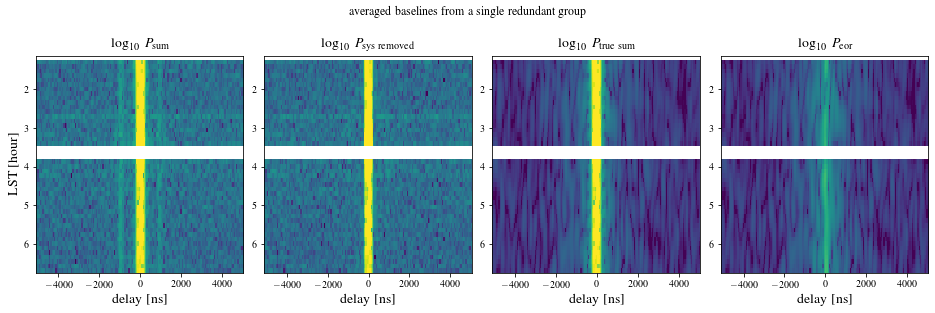

In [13]:
# plot redundantly averaged baseline type
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(wspace=0.1)

key = (0, uvp_rm_avg.get_blpairs()[0], 'pI')
dlys = uvps_eor[0].get_dlys(key[0]) * 1e9

ax = axes[0]
cax = ax.imshow(np.log10(np.abs(uvp_sum_avg.get_data(key).real)), aspect='auto',
                extent=[dlys[0], dlys[-1], sum_lsts[-1], sum_lsts[0]], vmin=5, vmax=13)
ax.set_xlabel('delay [ns]', fontsize=14); ax.set_ylabel('LST [hour]', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm sum}$', fontsize=14)

ax = axes[1]
cax = ax.imshow(np.log10(np.abs(uvp_rm_avg.get_data(key).real)), aspect='auto',
                extent=[dlys[0], dlys[-1], sum_lsts[-1], sum_lsts[0]], vmin=5, vmax=13)
ax.set_xlabel('delay [ns]', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm sys\ removed}$', fontsize=14)

ax = axes[2]
cax = ax.imshow(np.log10(np.abs(uvp_tsum_avg.get_data(key).real)), aspect='auto',
                extent=[dlys[0], dlys[-1], sum_lsts[-1], sum_lsts[0]], vmin=5, vmax=13)
ax.set_xlabel('delay [ns]', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm true\ sum}$', fontsize=14)

ax = axes[3]
cax = ax.imshow(np.log10(np.abs(uvp_eor_avg.get_data(key).real)), aspect='auto', 
                extent=[dlys[0], dlys[-1], eor_lsts[-1], eor_lsts[0]], vmin=5, vmax=13)
ax.set_xlabel('delay [ns]', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm eor}$', fontsize=14)

fig.suptitle("averaged baselines from a single redundant group", y=1.05)

__Figure 12__ | Redundantly averaged spectrum waterfall for the sum (left), sum plus systematic removal (middle left), true sum (middle right) and EoR (right).

In [14]:
# spherically average
# this is too large a computation to perform on the full object
# so we need to perform this on a per-integration basis, and then
# recombine into a single object
dk = 0.05
kbins = np.arange(0.0, 2.5, dk)

uvp_eor_sphs = []
uvp_rm_sphs = []
uvp_sum_sphs = []
uvp_tsum_sphs = []

for i in range(uvp_rm_avg.Ntimes):
    uvp = uvp_rm_avg.select(times=[np.unique(uvp_rm_avg.time_avg_array)[i]], inplace=False)
    uvp_rm_sphs.append(hp.grouping.spherical_average(uvp, kbins, dk, error_weights='P_N'))

    uvp = uvp_eor_avg.select(times=[np.unique(uvp_eor_avg.time_avg_array)[i]], inplace=False)
    uvp_eor_sphs.append(hp.grouping.spherical_average(uvp, kbins, dk, error_weights='P_N'))
    
    uvp = uvp_sum_avg.select(times=[np.unique(uvp_sum_avg.time_avg_array)[i]], inplace=False)
    uvp_sum_sphs.append(hp.grouping.spherical_average(uvp, kbins, dk, error_weights='P_N'))
    
    uvp = uvp_tsum_avg.select(times=[np.unique(uvp_tsum_avg.time_avg_array)[i]], inplace=False)
    uvp_tsum_sphs.append(hp.grouping.spherical_average(uvp, kbins, dk, error_weights='P_N'))

# combine
uvp_eor_sph = hp.uvpspec.combine_uvpspec(uvp_eor_sphs, merge_history=False, verbose=False)
uvp_rm_sph = hp.uvpspec.combine_uvpspec(uvp_rm_sphs, merge_history=False, verbose=False)
uvp_sum_sph = hp.uvpspec.combine_uvpspec(uvp_sum_sphs, merge_history=False, verbose=False)
uvp_tsum_sph = hp.uvpspec.combine_uvpspec(uvp_tsum_sphs, merge_history=False, verbose=False)

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


(0, 1.2)

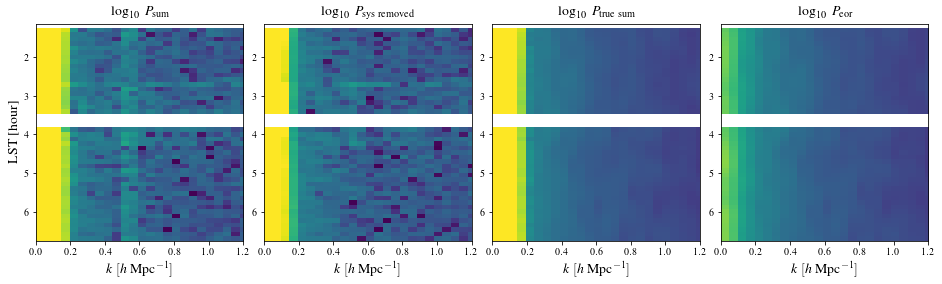

In [159]:
# plot redundantly averaged baseline type
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(wspace=0.1)

xlim = 0, 1.2

spw = 1
key = (spw, uvp_rm_avg.get_blpairs()[0], 'pI')

ax = axes[0]
cax = ax.imshow(np.log10(np.abs(uvp_sum_sph.get_data(key).real)), aspect='auto',
                extent=[kbins[0], kbins[-1], sum_lsts[-1], sum_lsts[0]], vmin=5, vmax=11)
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14); ax.set_ylabel('LST [hour]', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm sum}$', fontsize=14)
ax.set_xlim(xlim)

ax = axes[1]
cax = ax.imshow(np.log10(np.abs(uvp_rm_sph.get_data(key).real)), aspect='auto',
                extent=[kbins[0], kbins[-1], sum_lsts[-1], sum_lsts[0]], vmin=5, vmax=11)
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm sys\ removed}$', fontsize=14)
ax.set_xlim(xlim)

ax = axes[2]
cax = ax.imshow(np.log10(np.abs(uvp_tsum_sph.get_data(key).real)), aspect='auto',
                extent=[kbins[0], kbins[-1], sum_lsts[-1], sum_lsts[0]], vmin=5, vmax=11)
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm true\ sum}$', fontsize=14)
ax.set_xlim(xlim)

ax = axes[3]
cax = ax.imshow(np.log10(np.abs(uvp_eor_sph.get_data(key).real)), aspect='auto', 
                extent=[kbins[0], kbins[-1], eor_lsts[-1], eor_lsts[0]], vmin=5, vmax=11)
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=14)
ax.set_title(r'$\log_{10}\ P_{\rm eor}$', fontsize=14)
ax.set_xlim(xlim)

__Figure 13__ | Waterfalls of spherically averaged power spectra.

In [246]:
# set an LST cut and time-average
lst_cut = 1.4, 2.8
sum_lsts = np.unique(uvp_sum_sph.lst_avg_array) * 12 / np.pi
tinds = (sum_lsts >= lst_cut[0]) & (sum_lsts <= lst_cut[1])

# spherically averaged
uvp_sum_sph_tavg = uvp_sum_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_tsum_sph_tavg = uvp_tsum_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_rm_sph_tavg = uvp_rm_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_eor_sph_tavg = uvp_eor_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)

uvp_sum_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_tsum_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_rm_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_eor_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])

# non-spherically averaged
uvp_sum_tavg = uvp_sum_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_tsum_tavg = uvp_tsum_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_rm_tavg = uvp_rm_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_eor_tavg = uvp_eor_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)

uvp_sum_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_tsum_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_rm_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_eor_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])

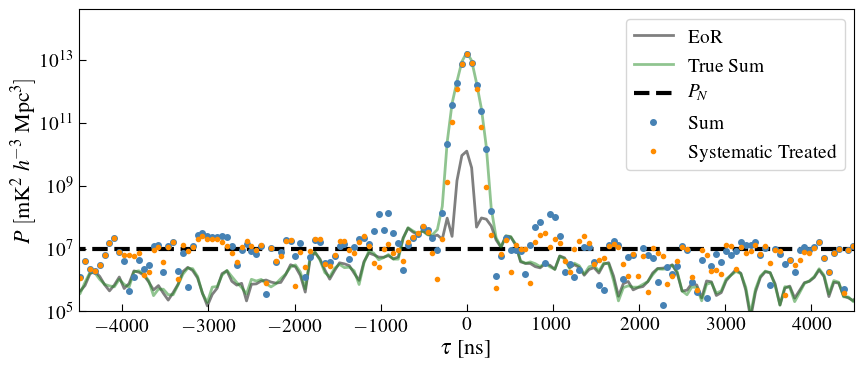

In [183]:
# spectrum plot
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.tick_params(labelsize=14, direction='in', size=5)

spw = 1
key = (spw, uvp_rm_tavg.get_blpairs()[0], 'pI')
dlys = uvps_eor[0].get_dlys(spw) * 1e9
tind = 0

p0, = ax.plot(dlys, uvp_rm_tavg.get_stats('P_N', key).real[tind], c='k', lw=3, ls='--')
p1, = ax.plot(dlys, uvp_eor_tavg.get_data(key).real[tind], lw=2, c='k', alpha=0.5)
p2, = ax.plot(dlys, uvp_tsum_tavg.get_data(key).real[tind], lw=2, c='forestgreen', alpha=0.5)
p3 = ax.errorbar(dlys, np.abs(uvp_sum_tavg.get_data(key).real[tind]), ls='', marker='o', ms=4, c='steelblue')
p4 = ax.errorbar(dlys, np.abs(uvp_rm_tavg.get_data(key).real[tind]), ls='', marker='o', ms=3, c='darkorange')

ax.set_yscale('log')
ax.set_xlim(-4500, 4500)
ax.set_ylim(1e5, 4e14)
#ax.grid()
ax.set_xlabel(r'$\tau$ [ns]', fontsize=16)
ax.set_ylabel(r'$P\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=16)
ax.legend([p1, p2, p0, p3, p4], ['EoR', 'True Sum', r'$P_N$', 'Sum', 'Systematic Treated'], loc=1, fontsize=14, ncol=1)

__Figure 13__ | Redundant and time-averaged power spectrum, showing agreement of the data (blue and orange) with the predicted thermal noise at high delay.

/lustre/aoc/projects/hera/nkern/Software/hera_pspec/hera_pspec/plot.py:844: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


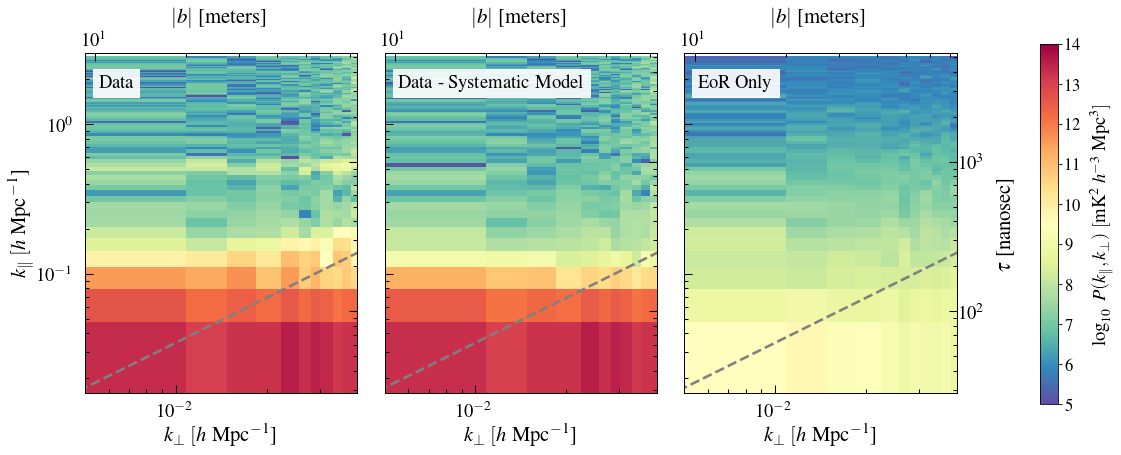

In [247]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), dpi=75)
fig.subplots_adjust(wspace=0.1)

cmap = plt.get_cmap('Spectral_r')
cmap.set_under(cmap(0))
cmap.set_bad('k', alpha=0.8)
xlim = (5e-3, 4e-2)
ylim = (1.6e-2, 3e0)
bbox = dict(fc='w', boxstyle='square', alpha=0.9, ec='w')
spw = 1

ax = axes[0]
ax2, ax3 = wedge_plot(uvp_sum_tavg, ax, dly_label=False, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           component='abs-real', spw=spw)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.text(0.05, 0.9, "Data", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)

ax = axes[1]
ax2, ax3 = wedge_plot(uvp_rm_tavg, ax, dly_label=False, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           component='abs-real', spw=spw)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.set_yticklabels([]); ax.set_ylabel('')
ax.text(0.05, 0.9, "Data - Systematic Model", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)

ax = axes[2]
cbax = fig.add_axes([0.77, 0.1, 0.24, 0.8])
cbax.axis('off')
ax2, ax3 = wedge_plot(uvp_eor_tavg, ax, dly_label=True, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           cbax=cbax, component='abs-real', spw=spw)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.set_yticklabels([]); ax.set_ylabel('')
ax.text(0.05, 0.9, "EoR Only", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)
cbar = ax.collections[0].colorbar
cbar.set_label(r"$\log_{10}\ P(k_\parallel, k_\perp)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=18, labelpad=8)

#fig.savefig("plots/test4_wedge.pdf", dpi=100, bbox_inches='tight')

__Figure 14__ | Wedge plots of time-averaged sum power spectra without systematic treatment (left), with systematic treatment (middle) and of the EoR-only dataset (right).

In [99]:
# estimate cosmic variance from EoR
eor_cv = []
for spw in uvp_eor_sph.spw_array:
    k = (spw, uvp_eor_sph.get_blpairs()[0], 'pI')
    eor_cv.append(np.var(uvp_eor_sph.get_data(k, omit_flags=True).real.squeeze(), axis=0))
# effective degrees of freedom is time range / beam crossing (~40 minutes)
eff_dof = (uvp_eor_sph.lst_avg_array.max() - uvp_eor_sph.lst_avg_array.min()) * 12 * 60 / np.pi / 40.0
eor_cv = np.array(eor_cv) / eff_dof

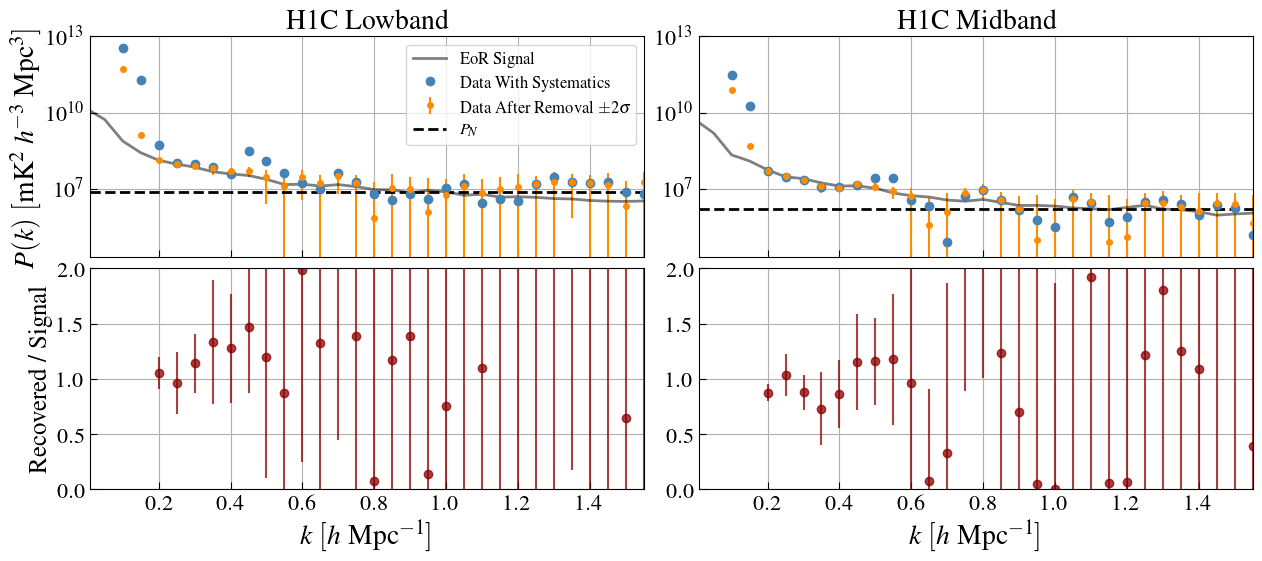

In [249]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6), dpi=100)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

xlim = 0.01, 1.55
titles = ['H1C Lowband', 'H1C Midband']

for i, spw in enumerate([0, 1]):
    key = (spw, uvp_sum_sph_tavg.get_blpairs()[0], 'pI')

    eor_sig = uvp_eor_sph_tavg.get_data(key).real[0]
    sum_sig = uvp_sum_sph_tavg.get_data(key).real[0] * abscal_corr[spw]
    tsum_sig = uvp_tsum_sph_tavg.get_data(key).real[0]
    rm_sig = uvp_rm_sph_tavg.get_data(key).real[0] * abscal_corr[spw]
    rm_err = uvp_rm_sph_tavg.get_stats('P_SN', key).real[0] * abscal_corr[spw]
    P_N = np.median(uvp_rm_sph_tavg.get_stats('P_N', key).real) * abscal_corr[spw]

    ax = axes[0, i]
    ax.tick_params(labelsize=16, direction='in', size=5)
    p1, = ax.plot(kbins, eor_sig, lw=2, c='k', alpha=0.5)
    p2 = ax.errorbar(kbins, np.abs(sum_sig), ls='', marker='o', ms=6, c='steelblue')
    p3 = ax.errorbar(kbins, np.abs(rm_sig), ls='', marker='o', ms=4, c='darkorange',
                     yerr=2 * rm_err, lw=1.5)
    p5 = ax.axhline(P_N, c='k', ls='--', lw=2)

    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(2e4, 1e13)
    ax.grid()
    if i == 0:
        ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=20)
        ax.legend([p1, p2, p3, p5],
                  ['EoR Signal', 'Data With Systematics', r'Data After Removal $\pm2\sigma$', r'$P_N$'],
                  loc=1, fontsize=12, ncol=1)
    ax.set_xticklabels([])
    ax.set_title(titles[i], fontsize=20)

    ax = axes[1, i]
    ax.tick_params(labelsize=16, direction='in', size=5)
    res = np.abs(rm_sig) - (eor_sig)
    res_std = np.std(res[10:])
    p1 = ax.errorbar(kbins, np.abs(rm_sig) / eor_sig, yerr=2 * rm_err / eor_sig,
                     c='darkred', alpha=0.75, ls='', marker='o', ms=6, lw=1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(0, 2)
    ax.grid()
    ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
    if i == 0:
        ax.set_ylabel('Recovered / Signal', fontsize=18)

#fig.savefig("plots/test4_recovered_pspec_lstcut1.pdf", dpi=100, bbox_inches='tight')

__Figure 15__ | Recovered power spectra (orange) with $2\sigma$ errorbars, plotted against the intrinsic EoR signal in the data (grey). The power in the orange relative to the grey are in agreement to within their associated uncertainty.

In [250]:
# set an LST cut and time-average
lst_cut = 4.2, 6.4
sum_lsts = np.unique(uvp_sum_sph.lst_avg_array) * 12 / np.pi
tinds = (sum_lsts >= lst_cut[0]) & (sum_lsts <= lst_cut[1])

# spherically averaged
uvp_sum_sph_tavg = uvp_sum_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_tsum_sph_tavg = uvp_tsum_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_rm_sph_tavg = uvp_rm_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_eor_sph_tavg = uvp_eor_sph.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)

uvp_sum_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_tsum_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_rm_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_eor_sph_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])

# non-spherically averaged
uvp_sum_tavg = uvp_sum_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_tsum_tavg = uvp_tsum_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_rm_tavg = uvp_rm_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)
uvp_eor_tavg = uvp_eor_avg.select(lsts=sum_lsts[tinds] * np.pi / 12, inplace=False)

uvp_sum_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_tsum_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_rm_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])
uvp_eor_tavg.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'])

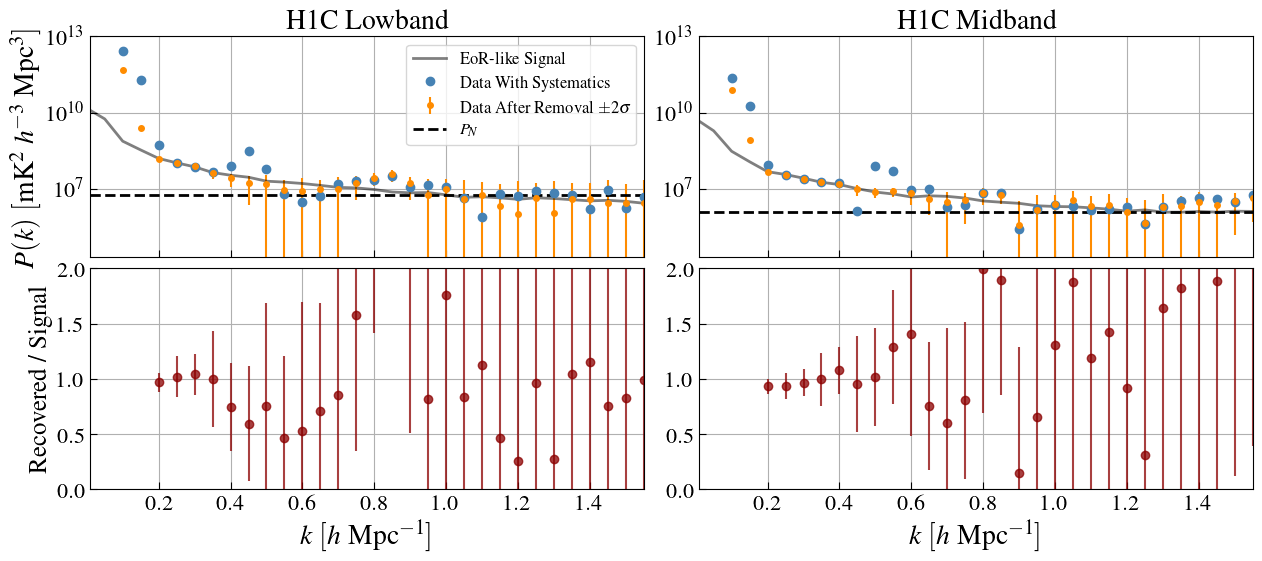

In [251]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6), dpi=100)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

xlim = 0.01, 1.55
titles = ['H1C Lowband', 'H1C Midband']

for i, spw in enumerate([0, 1]):
    key = (spw, uvp_sum_sph_tavg.get_blpairs()[0], 'pI')

    eor_sig = uvp_eor_sph_tavg.get_data(key).real[0]
    sum_sig = uvp_sum_sph_tavg.get_data(key).real[0] * abscal_corr[spw]
    tsum_sig = uvp_tsum_sph_tavg.get_data(key).real[0]
    rm_sig = uvp_rm_sph_tavg.get_data(key).real[0] * abscal_corr[spw]
    rm_err = uvp_rm_sph_tavg.get_stats('P_SN', key).real[0] * abscal_corr[spw]
    P_N = np.median(uvp_rm_sph_tavg.get_stats('P_N', key).real) * abscal_corr[spw]

    ax = axes[0, i]
    ax.tick_params(labelsize=16, direction='in', size=5)
    p1, = ax.plot(kbins, eor_sig, lw=2, c='k', alpha=0.5)
    p2 = ax.errorbar(kbins, np.abs(sum_sig), ls='', marker='o', ms=6, c='steelblue')
    p3 = ax.errorbar(kbins, np.abs(rm_sig), ls='', marker='o', ms=4, c='darkorange',
                     yerr=2 * rm_err, lw=1.5)
    p5 = ax.axhline(P_N, c='k', ls='--', lw=2)

    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(2e4, 1e13)
    ax.grid()
    if i == 0:
        ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=20)
        ax.legend([p1, p2, p3, p5],
                  ['EoR-like Signal', 'Data With Systematics', r'Data After Removal $\pm2\sigma$', r'$P_N$'],
                  loc=1, fontsize=12, ncol=1)
    ax.set_xticklabels([])
    ax.set_title(titles[i], fontsize=20)

    ax = axes[1, i]
    ax.tick_params(labelsize=16, direction='in', size=5)
    res = np.abs(rm_sig) - (eor_sig)
    res_std = np.std(res[10:])
    p1 = ax.errorbar(kbins, np.abs(rm_sig) / eor_sig, yerr=2 * rm_err / eor_sig,
                     c='darkred', alpha=0.75, ls='', marker='o', ms=6, lw=1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(0, 2)
    ax.grid()
    ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
    if i == 0:
        ax.set_ylabel('Recovered / Signal', fontsize=18)

#fig.savefig("plots/test4_recovered_pspec_lstcut2.pdf", dpi=100, bbox_inches='tight')

__Figure 16__ | Same as Figure 15 but for a later LST cut. 

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


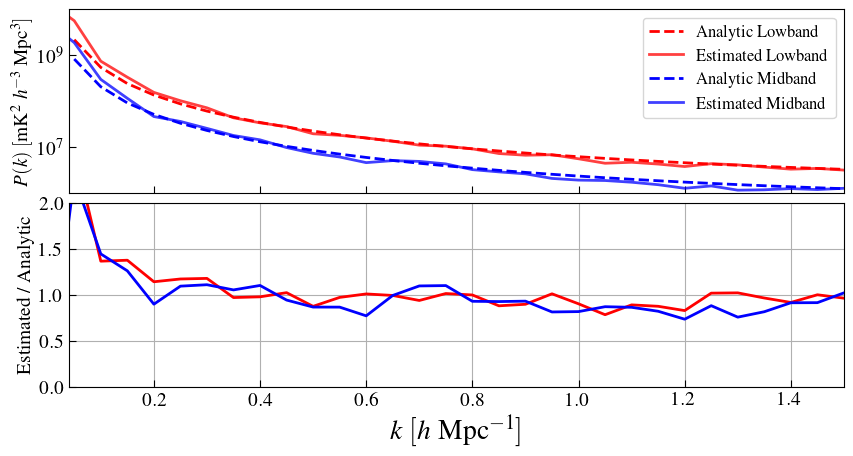

In [179]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), dpi=100)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

xlim = 0.04, 1.5
colors = ['r', 'b']
band = ['Lowband', 'Midband']

for i, spw in enumerate([0, 1]):
    key = (spw, uvp_sum_sph_tavg.get_blpairs()[0], 'pI')
    
    p_analytic = get_analytic_spectrum(uvp_eor_sph, spw, freq_dep=True)
    eor_sig = uvp_eor_sph_tavg.get_data(key).real[0]

    ax = axes[0]
    ax.tick_params(labelsize=14, direction='in', size=5)
    ax.plot(kbins, p_analytic, c=colors[i], lw=2, ls='--', label='Analytic {}'.format(band[i]))
    ax.plot(kbins, eor_sig, c=colors[i], lw=2, ls='-', alpha=0.75, label='Estimated {}'.format(band[i]))
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(1e6, 1e10)
    if i == 1:
        ax.set_ylabel(r'$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$', fontsize=14)
        ax.legend(fontsize=12, ncol=1)
    ax.set_xticklabels([])

    ax = axes[1]
    ax.tick_params(labelsize=14, direction='in', size=5)
    ax.plot(kbins, eor_sig / p_analytic, c=colors[i], lw=2)
    ax.set_xlim(xlim)
    ax.set_ylim(0, 2)
    ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
    if i == 0:
        ax.grid()
        ax.set_ylabel('Estimated / Analytic', fontsize=14)

__Figure 17__ | Analytic EoR power (dashed) compared to the estimated EoR power from the True EoR dataset (solid).

# Appendix A. Time Averaging Signal Loss <a class="anchor" id="tavg-sigloss"></a>

In [77]:
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_eor_notavg.h5", keep_open=False)
uvps_eor1 = load_red_uvps(psc, 'stokespol')

In [78]:
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_eor.h5", keep_open=False)
uvps_eor2 = load_red_uvps(psc, 'stokespol')

In [79]:
# redundant and time average
exclude_autos = False
exclude_cross = True

uvp_eor1_avg = red_avg(uvps_eor1, exclude_autos=exclude_autos, exclude_cross=exclude_cross)
uvp_eor2_avg = red_avg(uvps_eor2, exclude_autos=exclude_autos, exclude_cross=exclude_cross)

In [81]:
lst_cut = 1.2, 6.5
eor1_lsts = np.unique(uvp_eor1_avg.lst_avg_array) * 12 / np.pi
eor2_lsts = np.unique(uvp_eor2_avg.lst_avg_array) * 12 / np.pi

uvp_eor1_avg.select(times=np.unique(uvp_eor1_avg.time_avg_array)[(eor1_lsts > lst_cut[0])&(eor1_lsts<lst_cut[1])])
uvp_eor2_avg.select(times=np.unique(uvp_eor2_avg.time_avg_array)[(eor2_lsts > lst_cut[0])&(eor2_lsts<lst_cut[1])])

In [82]:
uvp_eor1_tavg = uvp_eor1_avg.average_spectra(time_avg=True, inplace=False)
uvp_eor2_tavg = uvp_eor2_avg.average_spectra(time_avg=True, inplace=False)

In [83]:
uvp_eor1_sph = hp.grouping.spherical_average(uvp_eor1_tavg, kbins, dk)
uvp_eor2_sph = hp.grouping.spherical_average(uvp_eor2_tavg, kbins, dk)

Text(0, 0.5, '$\\bar{P}_{\\rm EoR}\\ /\\ P_{\\rm EoR}$')

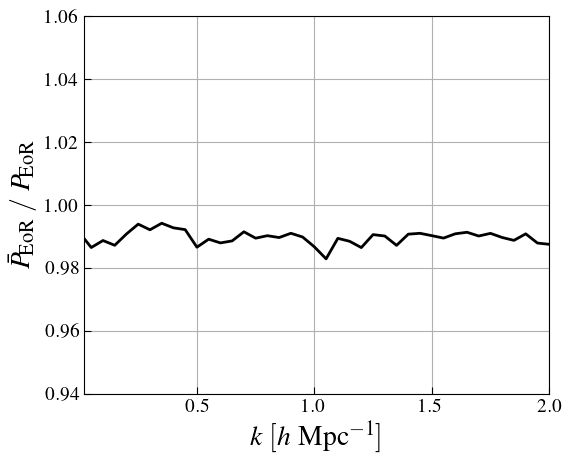

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=100)

ax.tick_params(labelsize=14, direction='in', size=5)
key = (0, uvp_eor1_sph.get_blpairs()[0], 'pI')

#p0, = ax.plot(sph_dlys * t2k, uvp_sum_sph.get_stats('P_SN', key)[0].real, c='k', lw=3, ls='--')
p1, = ax.plot(kbins, uvp_eor2_sph.get_data(key).real[0] / uvp_eor1_sph.get_data(key).real[0], lw=2, c='k')
#ax.plot(sph_k, p_fit)

ax.set_xlim(.02, 2)
ax.set_ylim(0.94, 1.06)
ax.grid()
ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}]$', fontsize=20)
ax.set_ylabel(r'$\bar{P}_{\rm EoR}\ /\ P_{\rm EoR}$', fontsize=20)

#fig.savefig("plots/test4_pspec_avg_EoR.pdf", dpi=100, bbox_inches='tight')

__Figure X__ | LST time averaging (i.e. fringe-rate filtering) signal loss test. Here we show the power spectrum ratio of the true EoR dataset with ($\bar{P}$) and without ($P$) a 214-second LST-averaging window. This demonstrates a $k$ independent loss of 1% in power, as expected given previous simulated work that motivated the 214-second window in the first place (that used an EoR model with a flat power spectrum).

# Appendix B. Crosstalk Filtering Signal Loss <a class="anchor" id="xtalk-sigloss"></a>

### Summary
Here we take a closer look at the step of crosstalk (or cross coupling) filtering that is applied to the visibilities. This step is one of the most sensitive steps with respect to signal loss (along with time averaging) and thus deserves closer attention. For more studies into crosstalk filtering see https://github.com/HERA-Team/H1C_IDR2/blob/master/notebooks/validation/xtalk_removal.ipynb.

In summary, we show that (as noted before in previous validation analyses), the adopted crosstalk filtering induces percent-level signal loss on the EoR signal, which is $k$ independent over the modes that are treated for crosstalk. However, xtalk filtering is also susceptible to boundary effects that can boost this loss if the edge bins are not truncated. Long, continuous regions of flagged data along the time axis can also have a similar effect.

In this appendix we introduce a new dataset, the **noise free** dataset. This data contains the true EoR and FG signal found in the **true sum** dataset but has been "uncalibrated" by the simulated bandpass and reflection gains on a nightly basis, has had the nightly flagging mask applied, has been "re-calibrated" with the bandpass gains derived from the Step 4 analysis, and then LST binned in the normal manner. We then inpaint the LST-binned data, and then calibrate it with the reflection gains derived in the Step 4 analysis. Lastly, we either pass the data through the xtalk filter or skip it, and then time-average them per usual. Note that xtalk systematics have not been added to the noise-free dataset, only reflections and bandpass gains. Comparing the noise-free dataset with and without xtalk subtraction therefore probes the amount of EoR signal loss induced by the step.

### Crosstalk Filtering Description

To remind us of how the H1C xtalk filter works, see https://ui.adsabs.harvard.edu/abs/2019ApJ...884..105K/abstract and https://ui.adsabs.harvard.edu/abs/2020ApJ...888...70K/abstract. We use SVD to model the xtalk systematic in delay space, and target delay modes starting at the baseline horizon out to 4000 ns. We then use a Gaussian Process as a low-pass filter to reject most of the EoR signal that may have leaked into our systematic model.
We low-pass filter the systematic model of each visibility such that all fringe-rate modes less than

\begin{align}
\large
|f_{\rm b}| < 0.024 \cdot |b_{\rm East-West}\ [{\rm meters}]| - 0.229\ {\rm mHz}
\end{align}

are kept in the model, rejecting fringe-rate structure that falls outside of this region. This limit is derived in the former paper (Figure 14), and is designed to keep $\ge99\%$ of EoR power in the visibilities (**and is specific to the H1C beam**).

In [861]:
# load noise free
#psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
#                         "pspec_sum_uncal_PTK.h5", keep_open=False)
#uvps_nf = load_red_uvps(psc, 'stokespol')

# load noise free with xtalk
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_eor_PXTK.h5", keep_open=False)
uvps_nfx = load_red_uvps(psc, 'stokespol')

# load true eor
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_eor_PTK.h5", keep_open=False)
uvps_eor = load_red_uvps(psc, 'stokespol')


----------------------------------------
pspec_eor_PXTK.h5


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
length [m],15.0,25.0,25.0,29.0,29.0,29.0,39.0,39.0,39.0,39.0,...,67.0,67.0,67.0,73.0,74.0,76.0,78.0,78.0,78.0,78.0
angle [deg],180.0,30.0,150.0,60.0,120.0,180.0,19.0,41.0,139.0,161.0,...,109.0,131.0,169.0,180.0,120.0,150.0,79.0,101.0,139.0,161.0
Nblpairs,169.0,121.0,100.0,100.0,81.0,121.0,36.0,64.0,81.0,64.0,...,9.0,9.0,9.0,1.0,9.0,4.0,1.0,1.0,4.0,1.0



----------------------------------------
pspec_eor_PTK.h5


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
length [m],15.0,25.0,25.0,29.0,29.0,29.0,39.0,39.0,39.0,39.0,...,67.0,67.0,67.0,73.0,74.0,76.0,78.0,78.0,78.0,78.0
angle [deg],180.0,30.0,150.0,60.0,120.0,180.0,19.0,41.0,139.0,161.0,...,109.0,131.0,169.0,180.0,120.0,150.0,79.0,101.0,139.0,161.0
Nblpairs,169.0,121.0,100.0,100.0,81.0,121.0,36.0,64.0,81.0,64.0,...,9.0,9.0,9.0,1.0,9.0,4.0,1.0,1.0,4.0,1.0


In [868]:
uvps_nf = copy.deepcopy(uvps_nfx)

In [869]:
for u1, u2, u3 in zip(uvps_nf, uvps_nfx, uvps_eor):
    for spw in u1.spw_array:
        u1.integration_array[spw] = (~np.isclose(u1.integration_array[spw], 0)).astype(np.float)
        u2.integration_array[spw] = (~np.isclose(u2.integration_array[spw], 0)).astype(np.float)
    u3.integration_array = copy.deepcopy(u2.integration_array)

In [870]:
# redundant and time average
exclude_autos = True

uvp_nf_avg = red_avg(uvps_nf, exclude_autos=exclude_autos)
uvp_nfx_avg = red_avg(uvps_nfx, exclude_autos=exclude_autos)
uvp_eor_avg = red_avg(uvps_eor, exclude_autos=exclude_autos)

divide by zero encountered in log10
divide by zero encountered in log10


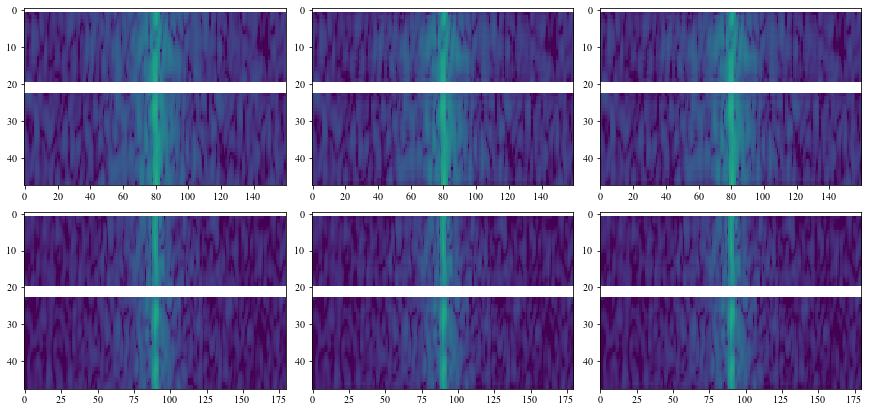

In [878]:
# plot waterfall
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
fig.subplots_adjust(wspace=0.1, hspace=0.15)

spw = 0
key = (spw, uvp_nf_avg.get_blpairs()[0], 'pI')
for i, u in enumerate([uvp_eor_avg, uvp_nf_avg, uvp_nfx_avg]):
    ax = axes[0, i]
    ax.tick_params(labelsize=10)
    cax = ax.imshow(np.log10(np.abs(u.get_data(key).real)), aspect='auto', vmin=5, vmax=14)

spw = 1
key = (spw, uvp_nf_avg.get_blpairs()[0], 'pI')
for i, u in enumerate([uvp_eor_avg, uvp_nf_avg, uvp_nfx_avg]):
    ax = axes[1, i]
    cax = ax.imshow(np.log10(np.abs(u.get_data(key).real)), aspect='auto', vmin=5, vmax=14)

In [873]:
# set time weighting and time average
for u in [uvp_nf_avg, uvp_nfx_avg, uvp_eor_avg]:
    for spw in u.spw_array:
        for blp in u.get_blpairs():
            blptinds = u.blpair_to_indices(blp)
            u.integration_array[spw][blptinds[:3]] = 0
            u.integration_array[spw][blptinds[-2:]] = 0
            u.integration_array[spw][blptinds[15:25]] = 0

uvp_nf_tavg = uvp_nf_avg.average_spectra(time_avg=True, inplace=False)
uvp_nfx_tavg = uvp_nfx_avg.average_spectra(time_avg=True, inplace=False)
uvp_eor_tavg = uvp_eor_avg.average_spectra(time_avg=True, inplace=False)

# multiply by abscal correction
for uvp in [uvp_nf_tavg, uvp_nfx_tavg]:
    for spw in uvp.spw_array:
        uvp.data_array[spw] *= abscal_corr[spw]

# spherically average
dk = 0.05
kbins = np.arange(0.0, 2.5, dk)
uvp_nf_sph = hp.grouping.spherical_average(uvp_nf_tavg, kbins, dk)
uvp_nfx_sph = hp.grouping.spherical_average(uvp_nfx_tavg, kbins, dk)
uvp_eor_sph = hp.grouping.spherical_average(uvp_eor_tavg, kbins, dk)

In [879]:
# spherically average at each integration
dk = 0.05
kbins = np.arange(0.0, 2.5, dk)

uvp_nf_sphs, uvp_nfx_sphs, uvp_eor_sphs = [], [], []
for i in range(uvp_nf_avg.Ntimes):
    uvp = uvp_nf_avg.select(times=np.unique(uvp_nf_avg.time_avg_array)[i:i+1], inplace=False)
    uvp_nf_sphs.append(hp.grouping.spherical_average(uvp, kbins, dk))

    uvp = uvp_nfx_avg.select(times=np.unique(uvp_nfx_avg.time_avg_array)[i:i+1], inplace=False)
    uvp_nfx_sphs.append(hp.grouping.spherical_average(uvp, kbins, dk))

    uvp = uvp_eor_avg.select(times=np.unique(uvp_eor_avg.time_avg_array)[i:i+1], inplace=False)
    uvp_eor_sphs.append(hp.grouping.spherical_average(uvp, kbins, dk))

In [880]:
# combine
uvp_nf_sph = hp.uvpspec.combine_uvpspec(uvp_nf_sphs, merge_history=False, verbose=False)
uvp_nfx_sph = hp.uvpspec.combine_uvpspec(uvp_nfx_sphs, merge_history=False, verbose=False)
uvp_eor_sph = hp.uvpspec.combine_uvpspec(uvp_eor_sphs, merge_history=False, verbose=False)

# multiply by abscal correction
for uvp in [uvp_nf_sph, uvp_nfx_sph]:
    for spw in uvp.spw_array:
        uvp.data_array[spw] *= abscal_corr[spw]

# set time weighting and time average
for u in [uvp_nf_sph, uvp_nfx_sph, uvp_eor_sph]:
    for spw in u.spw_array:
        #u.integration_array[spw][:3] = 0
        #u.integration_array[spw][-2:] = 0
        #u.integration_array[spw][18:25] = 0
        pass

uvp_nf_tavg = uvp_nf_sph.average_spectra(time_avg=True, inplace=False)
uvp_nfx_tavg = uvp_nfx_sph.average_spectra(time_avg=True, inplace=False)
uvp_eor_tavg = uvp_eor_sph.average_spectra(time_avg=True, inplace=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.tick_params(labelsize=14, direction='in', size=5)

spw = 0
key = (spw, uvp_nf_sph.get_blpairs()[0], 'pI')

cax = ax.imshow(uvp_nfx_sph.get_data(key).real / uvp_eor_sph.get_data(key).real, aspect='auto',
                cmap='seismic', vmin=0.6, vmax=1.4)
cbar = fig.colorbar(cax, ax=ax)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
spw = 0
key = (spw, uvp_nf_tavg.get_blpairs()[0], 'pI')
ax.plot(kbins, uvp_nfx_tavg.get_data(key).real[0] / uvp_nfx_tavg.get_data(key).real[0],
        c='k', lw=2, ls='-')
ax.set_ylim(0.9, 1.1)
#ax.set_ylim(0.2, 1.8)
ax.grid()

ax = axes[1]
spw = 0
key = (spw, uvp_nf_tavg.get_blpairs()[0], 'pI')
ax.plot(kbins, uvp_nfx_tavg.get_data(key).real[0] / uvp_eor_tavg.get_data(key).real[0],
        c='k', lw=2, ls='-')
ax.set_ylim(0.9, 1.1)
#ax.set_ylim(0.2, 1.8)
ax.grid()

divide by zero encountered in log10


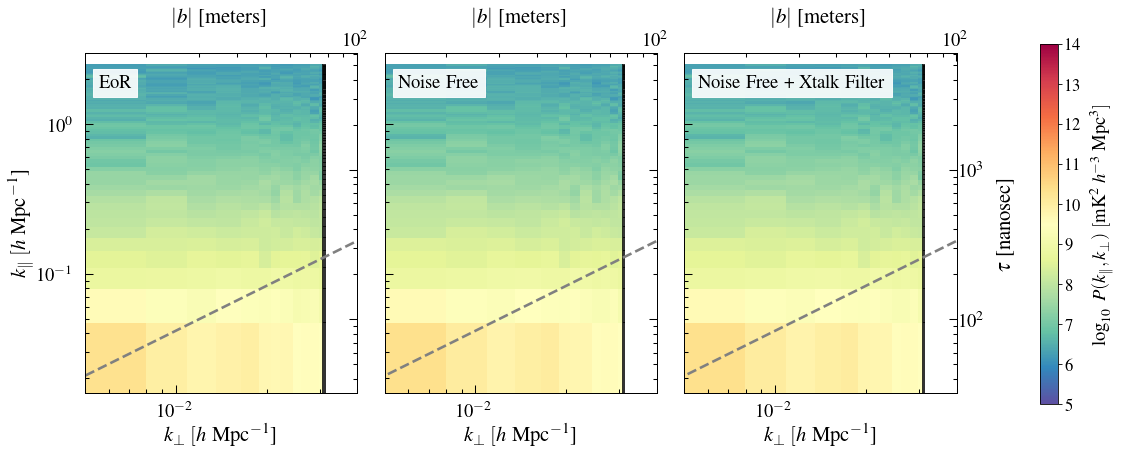

In [876]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), dpi=75)
fig.subplots_adjust(wspace=0.1)

cmap = plt.get_cmap('Spectral_r')
cmap.set_under(cmap(0))
cmap.set_bad('k', alpha=0.8)
xlim = (5e-3, 4e-2)
ylim = (1.6e-2, 3e0)
bbox = dict(fc='w', boxstyle='square', alpha=0.9, ec='w')
spw = 0

ax = axes[0]
ax2, ax3 = wedge_plot(uvp_eor_tavg, ax, dly_label=False, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           component='abs-real', spw=spw)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.text(0.05, 0.9, "EoR", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)

ax = axes[1]
ax2, ax3 = wedge_plot(uvp_nf_tavg, ax, dly_label=False, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           component='abs-real', spw=spw)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.set_yticklabels([]); ax.set_ylabel('')
ax.text(0.05, 0.9, "Noise Free", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)

ax = axes[2]
cbax = fig.add_axes([0.77, 0.1, 0.24, 0.8])
cbax.axis('off')
ax2, ax3 = wedge_plot(uvp_nfx_tavg, ax, dly_label=True, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           cbax=cbax, component='abs-real', spw=spw)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.set_yticklabels([]); ax.set_ylabel('')
ax.text(0.05, 0.9, "Noise Free + Xtalk Filter", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)
cbar = ax.collections[0].colorbar
cbar.set_label(r"$\log_{10}\ P(k_\parallel, k_\perp)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=18, labelpad=8)

#fig.savefig("plots/test4_wedge.pdf", dpi=100, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=75)
fig.subplots_adjust(wspace=0.1)

cmap = plt.get_cmap('seismic')
cmap.set_under(cmap(0))
cmap.set_bad('k', alpha=0.8)
xlim = (5e-3, 4e-2)
ylim = (1.6e-2, 3e0)
bbox = dict(fc='w', boxstyle='square', alpha=0.9, ec='w')
spw = 0

ax = axes[0]
uvp = copy.deepcopy(uvp_nf_tavg)
uvp.data_array[spw] /= uvp_eor_tavg.data_array[spw].real / abscal_corr[spw]
ax2, ax3 = wedge_plot(uvp, ax, dly_label=False, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           component='abs-real', spw=spw, log10=False, vmin=0.8, vmax=1.2)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.text(0.05, 0.9, "EoR", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)

ax = axes[1]
cbax = fig.add_axes([0.77, 0.1, 0.24, 0.8])
cbax.axis('off')
uvp = copy.deepcopy(uvp_nfx_tavg)
uvp.data_array[spw] /= uvp_eor_tavg.data_array[spw].real / abscal_corr[spw]
ax2, ax3 = wedge_plot(uvp, ax, dly_label=True, cmap=cmap, polpair=('pI', 'pI'), xlim=xlim, ylim=ylim,
           cbax=cbax, component='abs-real', log10=False, spw=spw, vmin=0.8, vmax=1.2)
ax.tick_params(labelsize=18); ax2.tick_params(labelsize=18); ax2.set_xticklabels([], minor=True)
ax3.tick_params(labelsize=18)
ax.set_yticklabels([]); ax.set_ylabel('')
ax.text(0.05, 0.9, "Noise Free + Xtalk Filter", fontsize=18, transform=ax.transAxes, c='k', bbox=bbox)
cbar = ax.collections[0].colorbar
cbar.set_label(r"$\log_{10}\ P(k_\parallel, k_\perp)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=18, labelpad=8)

#fig.savefig("plots/test4_wedge.pdf", dpi=100, bbox_inches='tight')

# Appendix C. Noise-Free Power Spectra Tests <a class="anchor" id="uncal-tests"></a>

In [410]:
# load visibility data
tfile = '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.26719.sum.true.uvh5'
ufile = '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.26719.sum.uncal.uvh5'
cfile = '/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/2458098_sum/zen.2458098.26719.sum.corrupt.smooth_abs.calfits'

uvd1 = UVData()
uvd1.read(tfile, bls=[(12, 13, 'xx')])
uvd2 = UVData()
uvd2.read(ufile, bls=[(12, 13, 'xx')])
uvc = UVCal()
uvc.read_calfits(cfile)
uvutils.uvcalibrate(uvd2, uvc, inplace=True, prop_flags=False)

Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


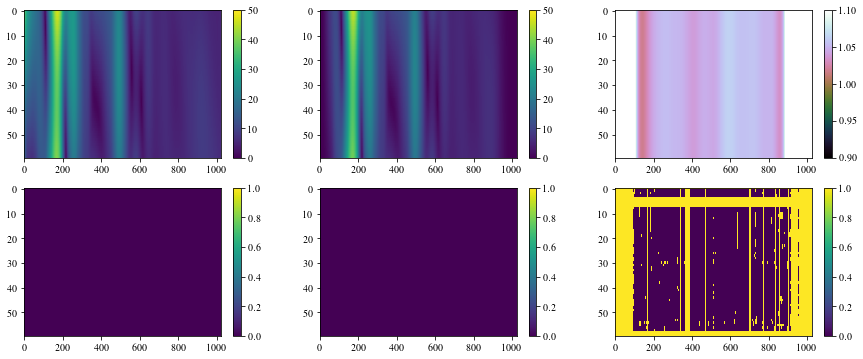

In [416]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

ax = axes[0, 0]
cax = ax.imshow(np.abs(uvd1.get_data(12, 13)), aspect='auto', vmin=0, vmax=50)
fig.colorbar(cax, ax=ax)

ax = axes[0, 1]
cax = ax.imshow(np.abs(uvd2.get_data(12, 13)), aspect='auto', vmin=0, vmax=50)
fig.colorbar(cax, ax=ax)

ax = axes[0, 2]
cax = ax.imshow(np.abs(uvd1.get_data(12, 13) / uvd2.get_data(12, 13)), aspect='auto',
                vmin=0.9, vmax=1.1, cmap='cubehelix')
fig.colorbar(cax, ax=ax)

ax = axes[1, 0]
cax = ax.imshow(uvd1.get_flags(12, 13), aspect='auto', vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)

ax = axes[1, 1]
cax = ax.imshow(uvd2.get_flags(12, 13), aspect='auto', vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)

ax = axes[1, 2]
cax = ax.imshow(np.abs(uvc.get_flags(12, 'Jee').T), aspect='auto', vmin=0, vmax=1)
fig.colorbar(cax, ax=ax)

In [542]:
rfile = '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.26719.sum.uncal.ref_uncal.uvh5'

uvd3 = UVData()
uvd3.read(rfile, bls=[(12, 13, 'xx')])

true_cfile = '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/gains/2458098.sum.true_gains.calfits'
true_rfile = '/lustre/aoc/projects/hera/Validation/test-4.0.0/data/gains/2458098.sum.reflections.calfits'
uvc1 = UVCal()
uvc1.read_calfits(true_cfile)
uvc2 = UVCal()
uvc2.read_calfits(true_rfile)

Telescope RIMEz calculation is not in known_telescopes.


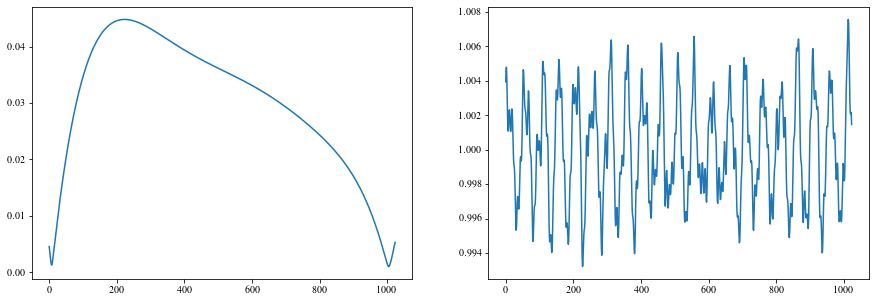

In [544]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.plot(np.abs(uvc1.get_gains(12, 'Jee')[:, 0]))

ax = axes[1]
ax.plot(np.abs(uvc2.get_gains(12, 'Jee')[:, 0]))

In [411]:
# this is true sum: no noise or systematics
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_true_sum.h5", keep_open=False)
uvps_tsum = load_red_uvps(psc, 'stokespol', spws=[1])

# this is uncal * cal
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_sum_uncal.h5", keep_open=False)
uvps_uc = load_red_uvps(psc, 'stokespol', spws=[0])

# this is (uncal * unrefcal) * cal
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_sum_uncal_ref_uncal.h5", keep_open=False)
uvps_urc = load_red_uvps(psc, 'stokespol', spws=[0])

# this is (uncal * unrefcal) * cal * refcal
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_sum_uncal_ref_uncal_cal.h5", keep_open=False)
uvps_rcc = load_red_uvps(psc, 'stokespol', spws=[0])

# this is EoR-only
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/PSPEC/"
                         "pspec_eor.h5", keep_open=False)
uvps_eor = load_red_uvps(psc, 'stokespol', spws=[1])

In [413]:
# down select to an LST cut
lst_cut = 1.6, 6.2
lst_cut = 0, 8
sum_lsts = np.unique(uvps_tsum[0].lst_avg_array) * 12 / np.pi
for uvp in uvps_tsum:
    uvp.select(lsts=sum_lsts[(sum_lsts >= lst_cut[0]) & (sum_lsts <= lst_cut[1])] * np.pi / 12)
for uvp in uvps_uc:
    uvp.select(lsts=sum_lsts[(sum_lsts >= lst_cut[0]) & (sum_lsts <= lst_cut[1])] * np.pi / 12)
for uvp in uvps_urc:
    uvp.select(lsts=sum_lsts[(sum_lsts >= lst_cut[0]) & (sum_lsts <= lst_cut[1])] * np.pi / 12)
for uvp in uvps_rcc:
    uvp.select(lsts=sum_lsts[(sum_lsts >= lst_cut[0]) & (sum_lsts <= lst_cut[1])] * np.pi / 12)
lsts = np.unique(uvps_tsum[0].lst_avg_array) * 12 / np.pi
dlys = uvp.get_dlys(0) * 1e9

In [414]:
# copy integration array
for uvp_u, uvp_r, uvp_ts, uvp_c in zip(uvps_uc, uvps_urc, uvps_tsum, uvps_rcc):
    # set nans to inf
    uvp_c.data_array[0][np.isnan(uvp_c.data_array[0])] = 0
    uvp_ts.integration_array[0] = uvp_r.integration_array[0]

In [415]:
# redundant average
exclude_autos = True
exclude_cross = False
uvp_tsum_avg = red_avg(uvps_tsum, exclude_autos=exclude_autos, exclude_cross=exclude_cross)
uvp_uc_avg = red_avg(uvps_uc, exclude_autos=exclude_autos, exclude_cross=exclude_cross)
uvp_urc_avg = red_avg(uvps_urc, exclude_autos=exclude_autos, exclude_cross=exclude_cross)
uvp_rcc_avg = red_avg(uvps_rcc, exclude_autos=exclude_autos, exclude_cross=exclude_cross)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


(-2500, 2500)

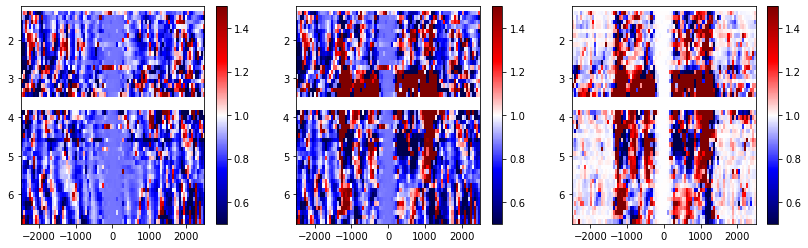

In [416]:
k = uvp_tsum_avg.get_all_keys()[0]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
xlim = -2500, 2500

ax = axes[0]
cax = ax.imshow(np.abs(uvp_uc_avg.get_data(k).real / uvp_tsum_avg.get_data(k).real), aspect='auto', vmin=0.5, vmax=1.5,
                cmap='seismic', extent=[dlys[0], dlys[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_xlim(xlim)

ax = axes[1]
cax = ax.imshow(np.abs(uvp_urc_avg.get_data(k).real / uvp_tsum_avg.get_data(k).real), aspect='auto', vmin=0.5, vmax=1.5,
                cmap='seismic', extent=[dlys[0], dlys[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_xlim(xlim)

ax = axes[2]
cax = ax.imshow(np.abs(uvp_urc_avg.get_data(k).real / uvp_uc_avg.get_data(k).real), aspect='auto', vmin=0.5, vmax=1.5,
                cmap='seismic', extent=[dlys[0], dlys[-1], lsts[-1], lsts[0]])
fig.colorbar(cax, ax=ax)
ax.set_xlim(xlim)

In [431]:
uvp_tsum_tavg = uvp_tsum_avg.average_spectra(time_avg=True, inplace=False)
uvp_uc_tavg = uvp_uc_avg.average_spectra(time_avg=True, inplace=False)
uvp_urc_tavg = uvp_urc_avg.average_spectra(time_avg=True, inplace=False)
uvp_rcc_tavg = uvp_rcc_avg.average_spectra(time_avg=True, inplace=False)

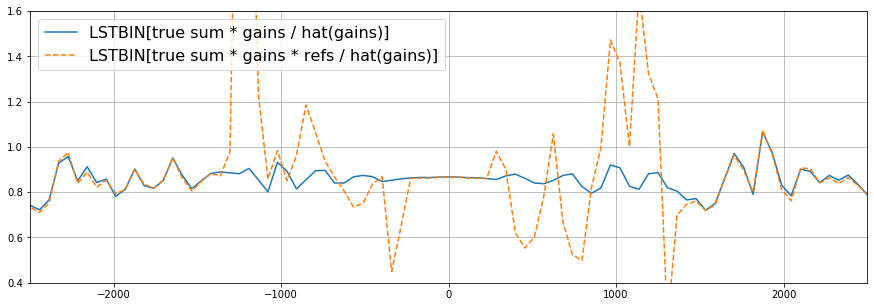

In [420]:
k = uvp_tsum_tavg.get_all_keys()[0]
dlys = uvp_urc_tavg.get_dlys(0) * 1e9

plt.figure(figsize=(15, 5))
plt.plot(dlys, np.abs(uvp_uc_tavg.get_data(k)[0] / uvp_tsum_tavg.get_data(k)[0]),
         label='LSTBIN[true sum * gains / hat(gains)]')
plt.plot(dlys, np.abs(uvp_urc_tavg.get_data(k)[0] / uvp_tsum_tavg.get_data(k)[0]), ls='--',
         label='LSTBIN[true sum * gains * refs / hat(gains)]')
plt.grid()
plt.xlim(-2500, 2500)
plt.ylim(0.4, 1.6)
plt.legend(fontsize=16)

In [442]:
dk = 0.05
kbins = np.arange(-2.5, 2.5, dk)

In [ ]:
uvp_tsum_sph = hp.grouping.spherical_average(uvp_tsum_tavg, kbins, dk)
uvp_uc_sph = hp.grouping.spherical_average(uvp_uc_tavg, kbins, dk)
uvp_urc_sph = hp.grouping.spherical_average(uvp_urc_tavg, kbins, dk)
uvp_rcc_sph = hp.grouping.spherical_average(uvp_rcc_tavg, kbins, dk)

In [453]:
uvp_tsum_sph = uvp_tsum_tavg.average_spectra(blpair_groups=[uvp_sum_tavg.get_blpairs()], inplace=False)
uvp_uc_sph = uvp_uc_tavg.average_spectra(blpair_groups=[uvp_uc_tavg.get_blpairs()], inplace=False)
uvp_urc_sph = uvp_urc_tavg.average_spectra(blpair_groups=[uvp_urc_tavg.get_blpairs()], inplace=False)
uvp_rcc_sph = uvp_rcc_tavg.average_spectra(blpair_groups=[uvp_rcc_tavg.get_blpairs()], inplace=False)

Text(0, 0.5, 'data / true sum')

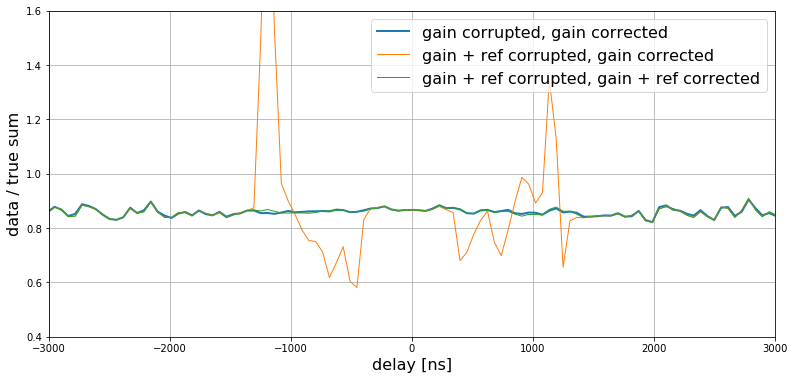

In [480]:
k = uvp_tsum_sph.get_all_keys()[0]
dlys = uvp_tsum_sph.get_dlys(0) * 1e9


fig, ax = plt.subplots(figsize=(13, 6))
xlim = -3000, 3000

ax.plot(dlys, np.abs(uvp_uc_sph.get_data(k)[0] / uvp_tsum_sph.get_data(k)[0]),
         label='gain corrupted, gain corrected', lw=2)
ax.plot(dlys, np.abs(uvp_urc_sph.get_data(k)[0] / uvp_tsum_sph.get_data(k)[0]),
         label='gain + ref corrupted, gain corrected', lw=1)
ax.plot(dlys, np.abs(uvp_rcc_sph.get_data(k)[0] / uvp_tsum_sph.get_data(k))[0],
        label='gain + ref corrupted, gain + ref corrected', lw=1)
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(0.4, 1.6)
ax.legend(fontsize=16)
ax.set_xlabel('delay [ns]', fontsize=16)
ax.set_ylabel('data / true sum', fontsize=16)

# Appendix D. Point Source Imaging <a class="anchor" id="imaging"></a>

In [161]:
@ticker.FuncFormatter
def degree_ticks(x, pos):
    return r"%.0f$^\circ$" % x
def set_xlim(ax, xlim, ycent):
    '''set xlim'''
    coords = wcs.wcs_world2pix(np.array([[xlim[0], ycent], [xlim[1], ycent]]), 1)
    ax.set_xlim(coords[:, 0])
def set_ylim(ax, ylim, xcent):
    '''set ylim'''
    coords = wcs.wcs_world2pix(np.array([[xcent, ylim[0]], [xcent, ylim[1]]]), 1)
    ax.set_ylim(coords[:, 1])

In [162]:
def plot_beam(ax, wcs, bmaj, bmin, bpa, frac=0.075, pad=3):
    # anchor position
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    cpix = xlim[0] + np.diff(xlim)[0] * frac, ylim[0] + np.diff(ylim)[0] * frac
    cworld = wcs.wcs_pix2world(np.array([cpix]), 0)
    dra = wcs.to_header()['CDELT1']
    ddec = wcs.to_header()['CDELT2']
    # make box
    bmaj_px = abs(bmaj / dra)
    bmin_px = abs(bmin / dra)
    l = bmaj_px * pad
    r = matplotlib.patches.Rectangle((cpix[0] - l/2, cpix[1] - l/2), l, l, facecolor='w', edgecolor='k',
                                     lw=0.75, zorder=100)
    ax.add_artist(r)
    e = matplotlib.patches.Ellipse(cpix, bmaj_px, bmin_px, bpa+90, facecolor='k', zorder=101)
    ax.add_artist(e)

In [163]:
def top_cbar(ax, cax, label='Jy/beam', size='4%', pad=0.1, length=5, labelsize=16, fontsize=20, minpad=1):
    divider = make_axes_locatable(ax)
    cbax = divider.append_axes('top', size=size, pad=pad)
    cbar = fig.colorbar(cax, cax=cbax, orientation='horizontal')
    cbax.grid(False)
    xax, yax = cbax.coords[0], cbax.coords[1]
    xax.set_ticks_position('t')
    xax.set_ticklabel_position('t')
    yax.set_ticks_visible(False)
    yax.set_ticklabel_visible(False)
    xax.tick_params(length=length, labelsize=labelsize)
    xax.set_axislabel(label, fontsize=fontsize, minpad=minpad)
    xax.set_axislabel_position('t')
    return cbax, cbar

In [122]:
%%bash
source2file.py --ra 30.05005 \
               --lon 21.4286 \
               --duration 1 \
               --start_jd 2458111 \
               --jd_files /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.*.HH.OCRSL.uvh5 \
               --get_filetimes


source LST (offset by 0.0 minutes) = 2.0166759776888603 Hours
----------------------------------------------------------------------

JD closest to zenith (offset by 0.0 minutes): 2458111.2676071473
----------------------------------------------------------------------

UTC time range of 1.0 minutes is:
"2017/12/23/18:24:51~2017/12/23/18:25:51"
centered on 2017/12/23/18:25:21
----------------------------------------------------------------------

file(s) closest to source (offset by 0.0 minutes) over 1.0 min duration:
 ['/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5']
----------------------------------------------------------------------

UTC time range of source in files above over 1.0 minutes is:
"2017/12/23/18:25:07~2017/12/23/18:25:50"
centered on 2017/12/23/18:25:37 = 2458111.2677998757
----------------------------------------------------------------------


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.0.28190.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.0.37586.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.0.56380.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Con

In [13]:
%%bash
source2file.py --ra 30.05005 \
               --lon 21.4286 \
               --duration 1 \
               --start_jd 2458111 \
               --jd_files /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.*.HH.OCRSL.uvh5 \
               --get_filetimes  


source LST (offset by 0.0 minutes) = 2.0166759776888603 Hours
----------------------------------------------------------------------

JD closest to zenith (offset by 0.0 minutes): 2458111.2676071473
----------------------------------------------------------------------

UTC time range of 1.0 minutes is:
"2017/12/23/18:24:51~2017/12/23/18:25:51"
centered on 2017/12/23/18:25:21
----------------------------------------------------------------------

file(s) closest to source (offset by 0.0 minutes) over 1.0 min duration:
 ['/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5']
----------------------------------------------------------------------

UTC time range of source in files above over 1.0 minutes is:
"2017/12/23/18:25:07~2017/12/23/18:25:50"
centered on 2017/12/23/18:25:37 = 2458111.2677998757
----------------------------------------------------------------------


antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.28190.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.37586.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.56380.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing wi

In [136]:
uvd = UVData()
uvd.read('/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5')

# select out 1 minute of time
lsts_min = np.unique(uvd.lst_array * 12 * 60 / np.pi)
tindx = [np.abs(l-120.20) < .5 for l in lsts_min]
times = np.unique(uvd.time_array)
uvd.select(times=times[tindx])
uvd.phase_to_time(Time(np.median(uvd.time_array), format='jd'))

uvd.write_uvfits("data/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvfits", spoof_nonessential=True)

antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [146]:
uvm = UVData()
uvm.read('/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5')

# select out 1 minute of time
lsts_min = np.unique(uvm.lst_array * 12 * 60 / np.pi)
tindx = [np.abs(l-120.20) < .5 for l in lsts_min]
times = np.unique(uvm.time_array)
uvm.select(times=times[tindx])
uvm.phase_to_time(Time(np.median(uvm.time_array), format='jd'))
uvm.flag_array = uvd.flag_array.copy()

uvm.write_uvfits("data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.uvfits", spoof_nonessential=True)

antenna_diameters is not set. Using known values for HERA.
LST values stored in /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/true_sum/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [147]:
%%bash
# image calibrated data
/home/casa/packages/RHEL7/release/casa-release-5.6.0-60/bin/casa --nologger --agg --nogui \
    -c /lustre/aoc/projects/hera/nkern/Software/casa_imaging/scripts/sky_image.py \
    --msin data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.uvfits \
    --out_dir data \
    --im_stem zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw0 \
    --source "gleam02" \
    --silence \
    --image_mfs \
    --spw 0:175~335 \
    --niter 0 \
    --threshold 1Jy \
    --weighting briggs \
    --robust -1 \
    --uvrange '>0m' \
    --pxsize 300 \
    --imsize 256 \
    --stokes "XXYY" \
    --deconvolver "hogbom" \
    --gridder "standard" \
    --pblimit -1 \
    --export_fits \
    --flag_autos \
    --cleanspace


The start-up time of CASA may vary
depending on whether the shared libraries
are cached or not.

]0;IPython: test-series/4IPython 5.1.0 -- An enhanced Interactive Python.

CASA 5.6.0-60   -- Common Astronomy Software Applications

Found an existing telemetry logfile: /users/nkern/.casa/casastats-560-60-e019836a3f82e2156-20200914-045802.log
Telemetry initialized. Telemetry will send anonymized usage statistics to NRAO.
You can disable telemetry by adding the following line to your ~/.casarc file:
EnableTelemetry: False
writing data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.ms

...flagging autocorrs
----------------------------------------

...cleaning namespace data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw0.gleam02*
----------------------------------------

...running MFS
----------------------------------------
...cleaning data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.ms for 0 iters with mask ''
...saving data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw0.gleam02.image
..

--> CrashReporter initialized.
2020-09-14 15:24:07	WARN	MSFitsInput::fillAntennaTable	HERA there is at least one gap in the antenna sequence found in the FITS AN table. Empty rows will be inserted into the ANTENNA table representing the gaps.
2020-09-14 15:24:07	WARN	MSFitsInput::fillExtraTable	No systemic velocity for field 0
2020-09-14 15:24:07	WARN	MSFitsInput::fillExtraTable	No rest frequency for field 0
2020-09-14 15:24:07	WARN	FlagDataHandler::preLoadColumn (file ../../flagging/Flagging/FlagDataHandler.cc, line 969)	PROCESSOR sub-table is empty. Assuming CORRELATOR type.
2020-09-14 15:24:08	WARN	task_tclean::SynthesisImagerVi2::makePB (file ../../synthesis/ImagerObjects/SynthesisImagerVi2.cc, line 2449)	The MS has multiple antenna diameters ..PB could be wrong 
2020-09-14 15:24:09	WARN	task_tclean::SIImageStore::restore (file ../../synthesis/ImagerObjects/SIImageStore.cc, line 2068)	Restoring with an empty model image. Only residuals will be processed to form the output restored 

In [148]:
%%bash
# image calibrated data
/home/casa/packages/RHEL7/release/casa-release-5.6.0-60/bin/casa --nologger --agg --nogui \
    -c /lustre/aoc/projects/hera/nkern/Software/casa_imaging/scripts/sky_image.py \
    --msin data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.uvfits \
    --out_dir data \
    --im_stem zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw1 \
    --source "gleam02" \
    --silence \
    --image_mfs \
    --spw 0:515~695 \
    --niter 0 \
    --threshold 1Jy \
    --weighting briggs \
    --robust -1 \
    --uvrange '>0m' \
    --pxsize 300 \
    --imsize 256 \
    --stokes "XXYY" \
    --deconvolver "hogbom" \
    --gridder "standard" \
    --pblimit -1 \
    --export_fits \
    --flag_autos \
    --cleanspace


The start-up time of CASA may vary
depending on whether the shared libraries
are cached or not.

]0;IPython: test-series/4IPython 5.1.0 -- An enhanced Interactive Python.

CASA 5.6.0-60   -- Common Astronomy Software Applications

Found an existing telemetry logfile: /users/nkern/.casa/casastats-560-60-e019836a3f82e2156-20200914-045802.log
Telemetry initialized. Telemetry will send anonymized usage statistics to NRAO.
You can disable telemetry by adding the following line to your ~/.casarc file:
EnableTelemetry: False
writing data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.ms

...flagging autocorrs
----------------------------------------

...cleaning namespace data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw1.gleam02*
----------------------------------------

...running MFS
----------------------------------------
...cleaning data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.ms for 0 iters with mask ''
...saving data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw1.gleam02.image
..

--> CrashReporter initialized.
2020-09-14 15:24:15	WARN	MSFitsInput::fillAntennaTable	HERA there is at least one gap in the antenna sequence found in the FITS AN table. Empty rows will be inserted into the ANTENNA table representing the gaps.
2020-09-14 15:24:15	WARN	MSFitsInput::fillExtraTable	No systemic velocity for field 0
2020-09-14 15:24:15	WARN	MSFitsInput::fillExtraTable	No rest frequency for field 0
2020-09-14 15:24:16	WARN	FlagDataHandler::preLoadColumn (file ../../flagging/Flagging/FlagDataHandler.cc, line 969)	PROCESSOR sub-table is empty. Assuming CORRELATOR type.
2020-09-14 15:24:17	WARN	task_tclean::SynthesisImagerVi2::makePB (file ../../synthesis/ImagerObjects/SynthesisImagerVi2.cc, line 2449)	The MS has multiple antenna diameters ..PB could be wrong 
2020-09-14 15:24:17	WARN	task_tclean::SIImageStore::restore (file ../../synthesis/ImagerObjects/SIImageStore.cc, line 2068)	Restoring with an empty model image. Only residuals will be processed to form the output restored 

In [ ]:
%%bash
# image calibrated data
/home/casa/packages/RHEL7/release/casa-release-5.6.0-60/bin/casa --nologger --agg --nogui \
    -c /lustre/aoc/projects/hera/nkern/Software/casa_imaging/scripts/sky_image.py \
    --msin data/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvfits \
    --out_dir data \
    --im_stem zen.grp1.of1.LST.0.46983.HH.OCRSL.spw0 \
    --source "gleam02" \
    --silence \
    --image_mfs \
    --spw 0:175~335 \
    --niter 0 \
    --threshold 1Jy \
    --weighting briggs \
    --robust -1 \
    --uvrange '>0m' \
    --pxsize 300 \
    --imsize 256 \
    --stokes "XXYY" \
    --deconvolver "hogbom" \
    --gridder "standard" \
    --pblimit -1 \
    --export_fits \
    --flag_autos \
    --cleanspace

In [ ]:
%%bash
# image calibrated data
/home/casa/packages/RHEL7/release/casa-release-5.6.0-60/bin/casa --nologger --agg --nogui \
    -c /lustre/aoc/projects/hera/nkern/Software/casa_imaging/scripts/sky_image.py \
    --msin data/zen.grp1.of1.LST.0.46983.HH.OCRSL.uvfits \
    --out_dir data \
    --im_stem zen.grp1.of1.LST.0.46983.HH.OCRSL.spw1 \
    --source "gleam02" \
    --silence \
    --image_mfs \
    --spw 0:515~695 \
    --niter 0 \
    --threshold 1Jy \
    --weighting briggs \
    --robust -1 \
    --uvrange '>0m' \
    --pxsize 300 \
    --imsize 256 \
    --stokes "XXYY" \
    --deconvolver "hogbom" \
    --gridder "standard" \
    --pblimit -1 \
    --export_fits \
    --flag_autos \
    --cleanspace

Set MJD-OBS to 58110.766708 from DATE-OBS'. [astropy.wcs.wcs]
Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


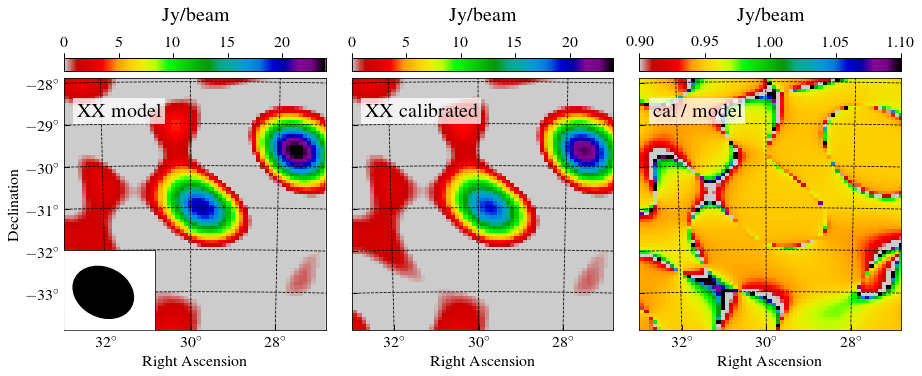

In [199]:
# plot calibrated data, flux model and residual
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.1)

center = (30, -31)
radius = 3
xlim = (center[0] + radius, center[0] - radius)
ylim = (center[1] - radius, center[1] + radius)
cmap = 'nipy_spectral_r'

h1 = fits.open("data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw0.gleam02.image.fits")
h2 = fits.open("data/zen.grp1.of1.LST.0.46983.HH.OCRSL.spw0.gleam02.image.fits")
wcs = WCS(h1[0], naxis=2)
ax = fig.add_subplot(131, projection=wcs)
xax, yax = ax.coords[0], ax.coords[1]
# factor of 2 comes from RIMEz Stokes convention vs hera_cal
cax = ax.imshow(h1[0].data[0, 1]*2, aspect='auto', origin='lower', vmin=0, vmax=24, cmap=cmap)
ax.text(0.05, 0.85, "XX model", fontsize=20, color='k', transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='w', ec='None', alpha=0.75, pad=.2))
ax.set_xlabel(r'Right Ascension', fontsize=16, labelpad=0.75)
ax.set_ylabel(r'Declination', fontsize=16, labelpad=0.75)
set_xlim(ax, xlim, center[1])
set_ylim(ax, ylim, center[0])
ax.tick_params(labelsize=16, direction='in')
xax.tick_params(length=5); yax.tick_params(length=5)
xax.set_ticks_position('b'); yax.set_ticks_position('l')
xax.set_major_formatter('d')
bmaj, bmin, bpa = casa_imaging.casa_utils.get_beam_info(h1)
plot_beam(ax, wcs, bmaj, bmin, bpa, frac=.15, pad=1.5)
cbax, cbar = top_cbar(ax, cax, size='5%', label='Jy/beam', pad=0.1, length=5, labelsize=16, fontsize=20, minpad=1)
ax.grid(color='k', ls='--')

wcs = WCS(h2[0], naxis=2)
ax = fig.add_subplot(132, projection=wcs)
xax, yax = ax.coords[0], ax.coords[1]
cax = ax.imshow(h2[0].data[0, 1]*2, aspect='auto', origin='lower', vmin=0, vmax=24, cmap=cmap)
ax.text(0.05, 0.85, "XX calibrated", fontsize=20, color='k', transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='w', ec='None', alpha=0.75, pad=.2))
ax.set_xlabel(r'Right Ascension', fontsize=16, labelpad=0.75)
set_xlim(ax, xlim, center[1])
set_ylim(ax, ylim, center[0])
ax.tick_params(labelsize=16, direction='in')
xax.tick_params(length=5); yax.tick_params(length=5)
xax.set_ticks_position('b'); yax.set_ticks_position('l')
xax.set_major_formatter('d')
yax.set_ticklabel_visible(False)
cbax, cbar = top_cbar(ax, cax, size='5%', label='Jy/beam', pad=0.1, length=5, labelsize=16, fontsize=20, minpad=1)
ax.grid(color='k', ls='--')

wcs = WCS(h2[0], naxis=2)
ax = fig.add_subplot(133, projection=wcs)
xax, yax = ax.coords[0], ax.coords[1]
cax = ax.imshow(h2[0].data[0, 0] / h1[0].data[0, 0], aspect='auto', origin='lower', vmin=0.9, vmax=1.1, cmap=cmap)
ax.text(0.05, 0.85, "cal / model", fontsize=20, color='k', transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='w', ec='None', alpha=0.75, pad=.2))
ax.set_xlabel(r'Right Ascension', fontsize=16, labelpad=0.75)
set_xlim(ax, xlim, center[1])
set_ylim(ax, ylim, center[0])
ax.tick_params(labelsize=16, direction='in')
xax.tick_params(length=5); yax.tick_params(length=5)
xax.set_ticks_position('b'); yax.set_ticks_position('l')
xax.set_major_formatter('d')
yax.set_ticklabel_visible(False)
cbax, cbar = top_cbar(ax, cax, size='5%', label='Jy/beam', pad=0.1, length=5, labelsize=16, fontsize=20, minpad=1)
ax.grid(color='k', ls='--')

In [200]:
(h2[0].data[0, 0][118:138,118:138].max() / h1[0].data[0, 0][118:138,118:138].max(),
 h2[0].data[0, 1][118:138,118:138].max() / h1[0].data[0, 1][118:138,118:138].max())

(0.95012176, 0.94247514)

In [350]:
1/np.mean([0.95012176, 0.94247514])

1.0567490626239533

Set MJD-OBS to 58110.766708 from DATE-OBS'. [astropy.wcs.wcs]
Set OBSGEO-B to   -30.721389 from OBSGEO-[XYZ].
Set OBSGEO-H to     1496.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


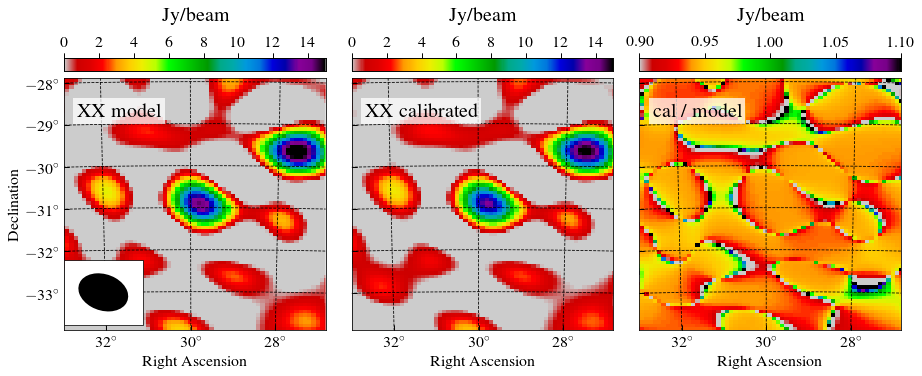

In [180]:
# plot calibrated data, flux model and residual
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.1)

center = (30, -31)
radius = 3
xlim = (center[0] + radius, center[0] - radius)
ylim = (center[1] - radius, center[1] + radius)
cmap = 'nipy_spectral_r'

h1 = fits.open("data/zen.grp1.of1.LST.0.46983.HH.true_sum.OCRSL.spw1.gleam02.image.fits")
h2 = fits.open("data/zen.grp1.of1.LST.0.46983.HH.OCRSL.spw1.gleam02.image.fits")
wcs = WCS(h1[0], naxis=2)
ax = fig.add_subplot(131, projection=wcs)
xax, yax = ax.coords[0], ax.coords[1]
# factor of 2 comes from RIMEz Stokes convention vs hera_cal
cax = ax.imshow(h1[0].data[0, 0]*2, aspect='auto', origin='lower', vmin=0, vmax=15, cmap=cmap)
ax.text(0.05, 0.85, "XX model", fontsize=20, color='k', transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='w', ec='None', alpha=0.75, pad=.2))
ax.set_xlabel(r'Right Ascension', fontsize=16, labelpad=0.75)
ax.set_ylabel(r'Declination', fontsize=16, labelpad=0.75)
set_xlim(ax, xlim, center[1])
set_ylim(ax, ylim, center[0])
ax.tick_params(labelsize=16, direction='in')
xax.tick_params(length=5); yax.tick_params(length=5)
xax.set_ticks_position('b'); yax.set_ticks_position('l')
xax.set_major_formatter('d')
bmaj, bmin, bpa = casa_imaging.casa_utils.get_beam_info(h1)
plot_beam(ax, wcs, bmaj, bmin, bpa, frac=.15, pad=1.5)
cbax, cbar = top_cbar(ax, cax, size='5%', label='Jy/beam', pad=0.1, length=5, labelsize=16, fontsize=20, minpad=1)
ax.grid(color='k', ls='--')

wcs = WCS(h2[0], naxis=2)
ax = fig.add_subplot(132, projection=wcs)
xax, yax = ax.coords[0], ax.coords[1]
cax = ax.imshow(h2[0].data[0, 0]*2, aspect='auto', origin='lower', vmin=0, vmax=15, cmap=cmap)
ax.text(0.05, 0.85, "XX calibrated", fontsize=20, color='k', transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='w', ec='None', alpha=0.75, pad=.2))
ax.set_xlabel(r'Right Ascension', fontsize=16, labelpad=0.75)
set_xlim(ax, xlim, center[1])
set_ylim(ax, ylim, center[0])
ax.tick_params(labelsize=16, direction='in')
xax.tick_params(length=5); yax.tick_params(length=5)
xax.set_ticks_position('b'); yax.set_ticks_position('l')
xax.set_major_formatter('d')
yax.set_ticklabel_visible(False)
cbax, cbar = top_cbar(ax, cax, size='5%', label='Jy/beam', pad=0.1, length=5, labelsize=16, fontsize=20, minpad=1)
ax.grid(color='k', ls='--')

wcs = WCS(h2[0], naxis=2)
ax = fig.add_subplot(133, projection=wcs)
xax, yax = ax.coords[0], ax.coords[1]
cax = ax.imshow(h2[0].data[0, 0] / h1[0].data[0, 0], aspect='auto', origin='lower', vmin=0.9, vmax=1.1, cmap=cmap)
ax.text(0.05, 0.85, "cal / model", fontsize=20, color='k', transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='w', ec='None', alpha=0.75, pad=.2))
ax.set_xlabel(r'Right Ascension', fontsize=16, labelpad=0.75)
set_xlim(ax, xlim, center[1])
set_ylim(ax, ylim, center[0])
ax.tick_params(labelsize=16, direction='in')
xax.tick_params(length=5); yax.tick_params(length=5)
xax.set_ticks_position('b'); yax.set_ticks_position('l')
xax.set_major_formatter('d')
yax.set_ticklabel_visible(False)
cbax, cbar = top_cbar(ax, cax, size='5%', label='Jy/beam', pad=0.1, length=5, labelsize=16, fontsize=20, minpad=1)
ax.grid(color='k', ls='--')

In [194]:
(h2[0].data[0, 0][118:138,118:138].max() / h1[0].data[0, 0][118:138,118:138].max(),
 h2[0].data[0, 1][118:138,118:138].max() / h1[0].data[0, 1][118:138,118:138].max())

(0.94078296, 0.92546046)

In [195]:
np.mean([0.94078296, 0.92546046])**2

0.8707161256733241

In [196]:
(1/np.mean([0.94078296, 0.92546046]))**2

1.1484799356698498

In [165]:
%%bash
source2file.py --ra 30.05005 \
               --lon 21.4286 \
               --duration 1 \
               --start_jd 2458098 \
               --jd_files /lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/abscal_true_sum_test_2458098/zen.2458098.*.sum.corrupt.uvh5 \
               --get_filetimes


source LST (offset by 0.0 minutes) = 2.016719477030893 Hours
----------------------------------------------------------------------

JD closest to zenith (offset by 0.0 minutes): 2458098.3031047937
----------------------------------------------------------------------

UTC time range of 1.0 minutes is:
"2017/12/10/19:15:58~2017/12/10/19:16:58"
centered on 2017/12/10/19:16:28
----------------------------------------------------------------------

file(s) closest to source (offset by 0.0 minutes) over 1.0 min duration:
 ['/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/abscal_true_sum_test_2458098/zen.2458098.29702.sum.corrupt.uvh5']
----------------------------------------------------------------------

UTC time range of source in files above over 1.0 minutes is:
"2017/12/10/19:16:01~2017/12/10/19:16:55"
centered on 2017/12/10/19:16:31 = 2458098.303144956
----------------------------------------------------------------------


Telescope RIMEz calculation is not in known_telescopes.
